# Comparing systems with and without accretion

In [2]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

import astropy.constants as const
import astropy.units as u

from astropy.visualization import quantity_support
quantity_support()

from ipywidgets import interact, IntSlider, FloatSlider

import seaborn as sns

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load and prep data

In [4]:
from importlib import reload
import sys
sys.path.append("../")

import mesagrid
reload(mesagrid);

sys.path.append("../helpers")
import mesaplot
reload(mesaplot);

In [5]:
usecols_history = ['model_number', 'star_age', 'log_Teff', 'log_L',
                   'center_h1', 'center_he4', 'star_mass']
cpus = 8

pairs = [(3, 0), (3, 0.65), (3.51317, 0), (3, 0.4)]
tracks = [mesagrid.Track(f"../output/mass_transfer_grid/M_{M}-MT_{MT}/",
                       usecols_history=usecols_history,
                       cpus=cpus, parameters=f"M={M}, MT={MT}") for M, MT in pairs]

In [6]:
def nuclear_time(M):
    return 7.5e9 * M.to(u.Msun).value**(-2.5) * u.yr

def thermal_time(R, M):
    return 2.2e7 * R.to(u.Rsun).value**(-1) * M.to(u.Msun).value**(-1.5) * u.yr

In [7]:
f"Nuclear Timescale: {nuclear_time(3 * u.Msun):1.2e}, Thermal Timescale: {thermal_time(2.2 * u.Rsun, 3 * u.Msun):1.2e}"

'Nuclear Timescale: 4.81e+08 yr, Thermal Timescale: 1.92e+06 yr'

# Radius Evolution

In [8]:
def get_radius(history):
    L = 10**(history["log_L"]).values * u.Lsun
    Teff = 10**(history["log_Teff"]).values * u.K
    return np.sqrt(L / (4 * np.pi * const.sigma_sb * Teff**4)).to(u.Rsun)

Parsing M=3, MT=0
Parsing M=3, MT=0.65
Parsing M=3.51317, MT=0
Parsing M=3, MT=0.4


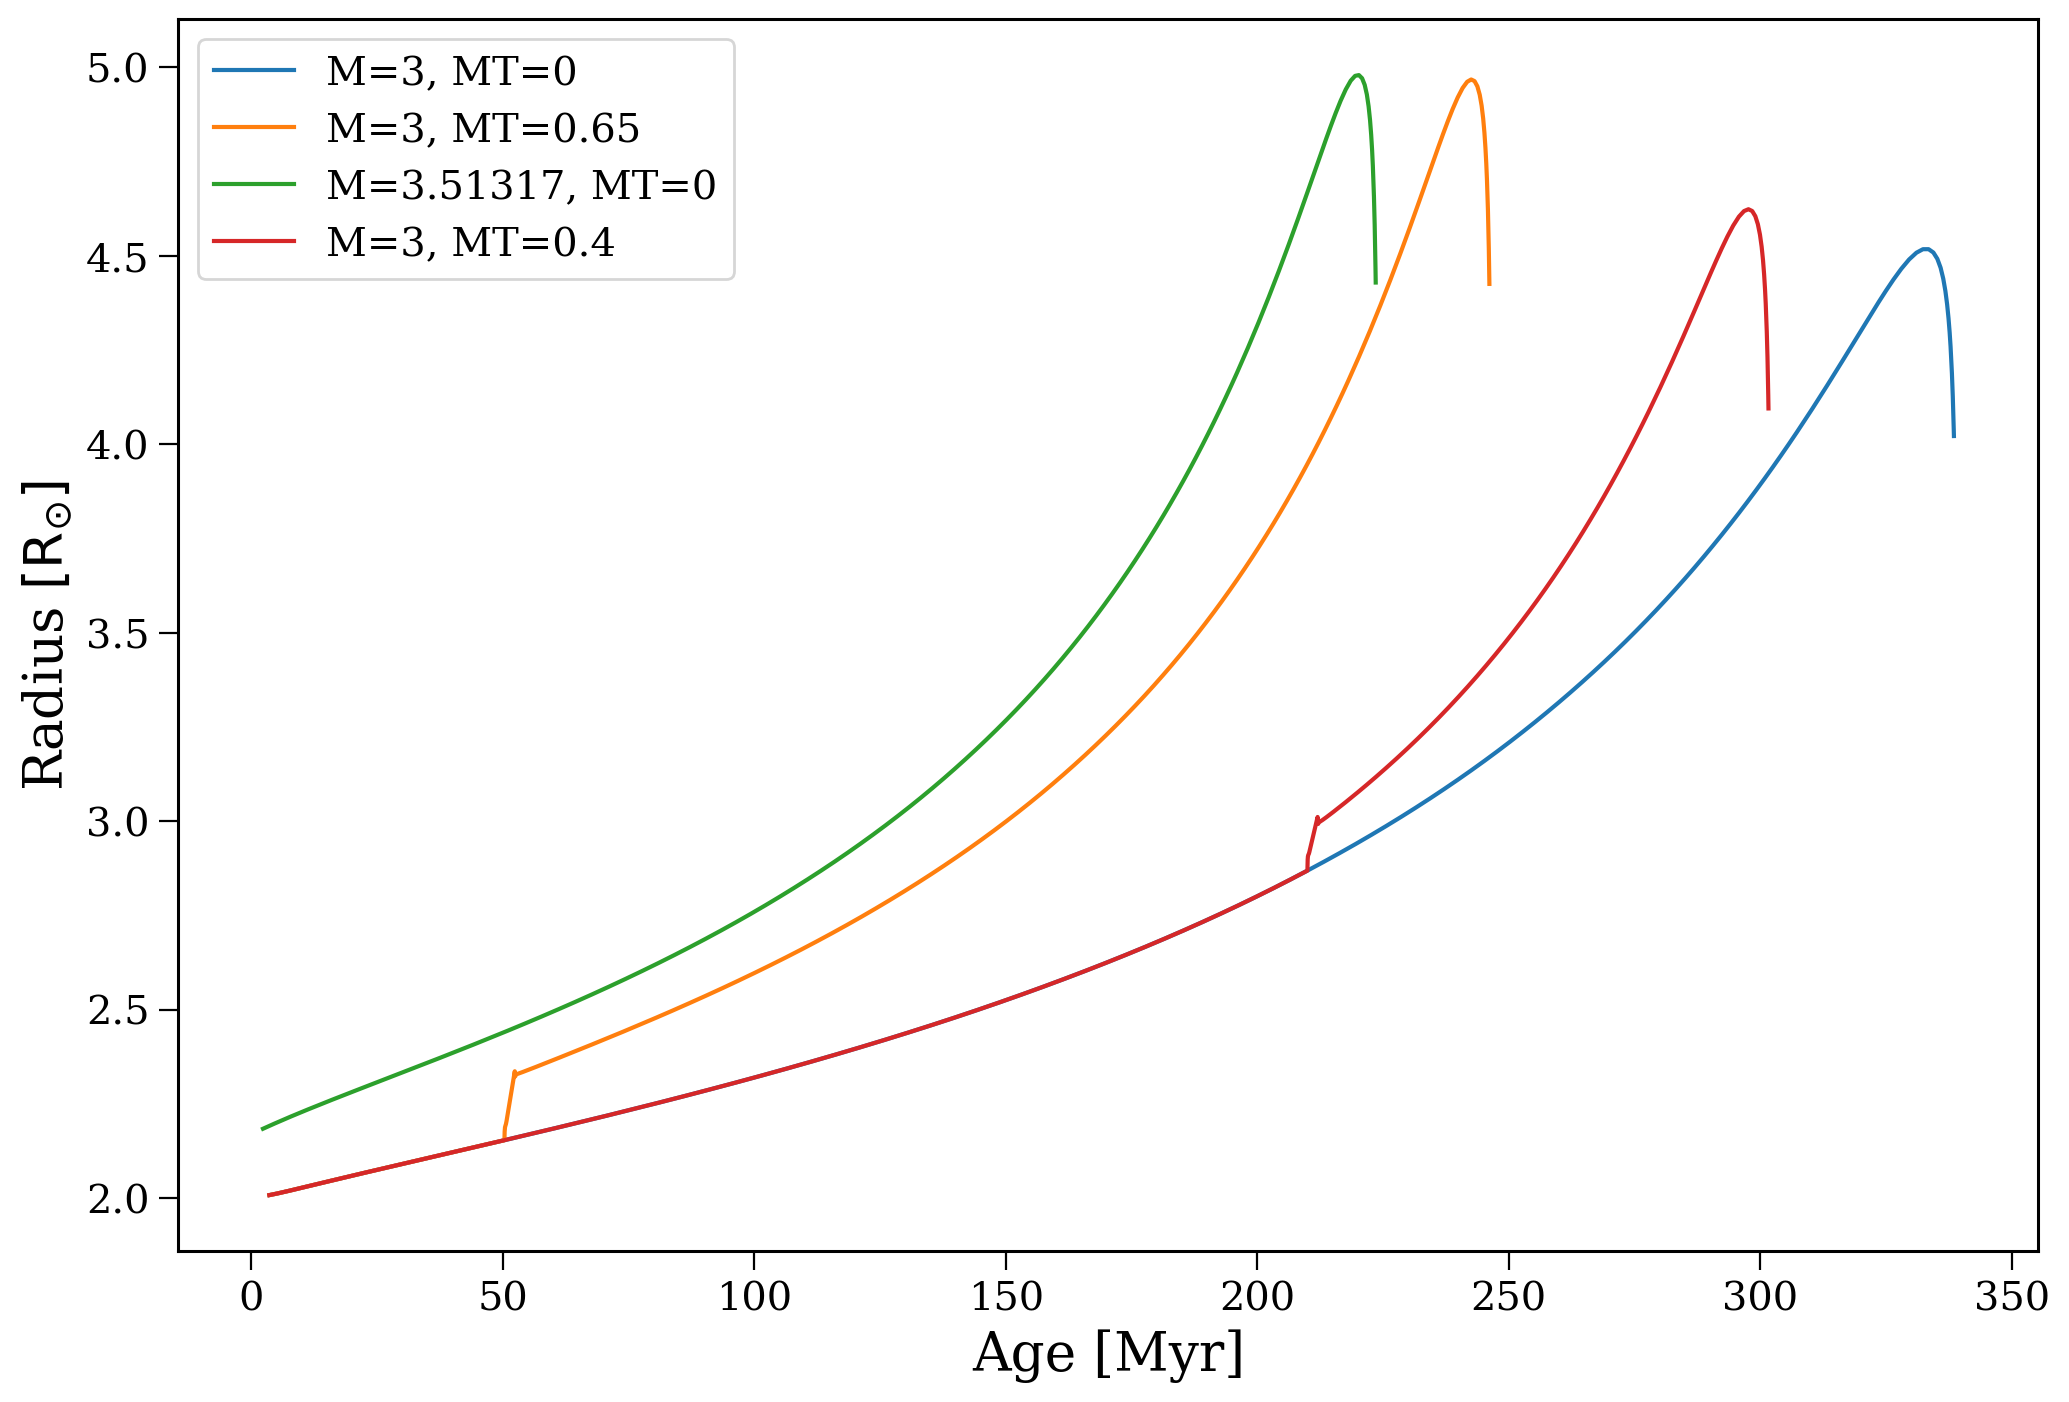

In [9]:
fig, ax = plt.subplots()

for i in range(len(tracks)):
    h = tracks[i].history[tracks[i].history["center_h1"] < 0.995 * tracks[i].history["center_h1"].max()]
    ax.plot(h["star_age"] / 1e6, get_radius(h), label=tracks[i].parameters)
ax.legend()
ax.set_xlabel("Age [Myr]")
ax.set_ylabel(r"Radius $[\rm R_{\odot}]$")
plt.show()

# HR Diagrams

## MT Track

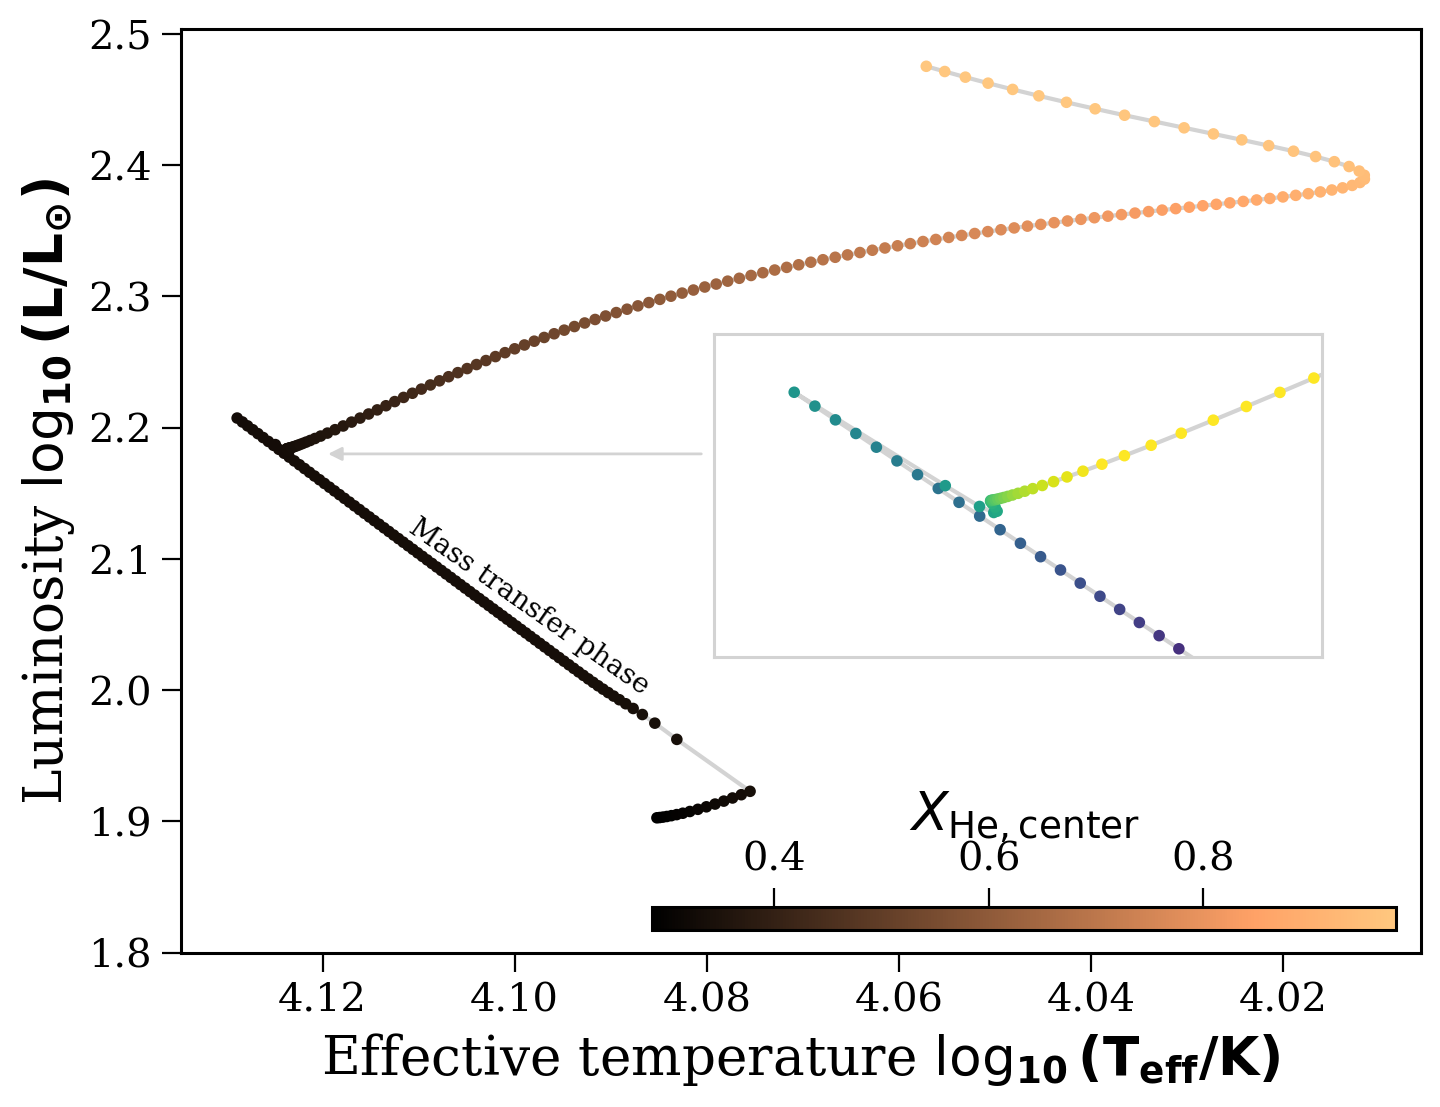

In [10]:
fig, ax = mesaplot.simple_hr(track=tracks[1], show=False)
ax.set_ylim(bottom=1.8)

inset_ax = ax.inset_axes([0.43, 0.32, 0.49, 0.35])
mesaplot.simple_hr(track=tracks[1], fig=fig, ax=inset_ax, show=False, cbar_var="model_number", cmap="viridis", vmin=100, vmax=150)
inset_ax.set_xlim(4.131, 4.115)
inset_ax.set_ylim(2.15, 2.22)
inset_ax.set_xticks([])
inset_ax.set_yticks([])

for spine in inset_ax.spines:
    inset_ax.spines[spine].set_color("lightgrey")

ax.annotate("", xy=(4.12, 2.18), xytext=(4.08, 2.18), arrowprops=dict(arrowstyle="-|>", color="lightgrey"))

ax.annotate("Mass transfer phase", xy=(0.18, 0.28), xycoords="axes fraction", rotation=-35)
plt.show()

## Comparison tracks

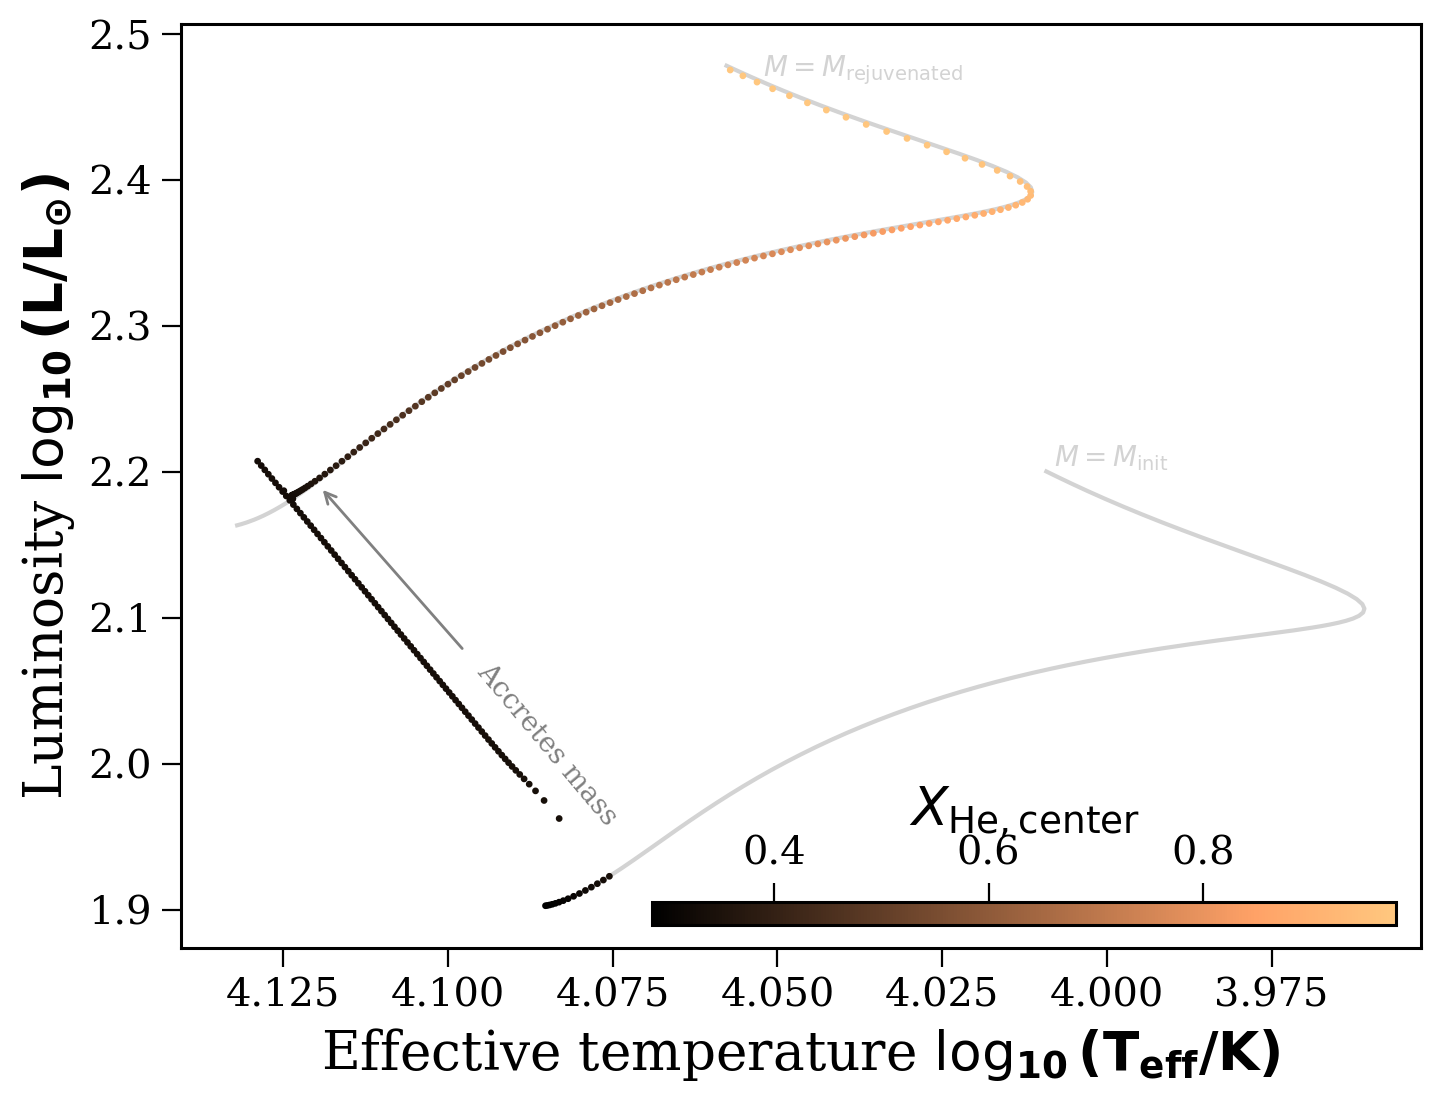

In [11]:
fig, ax = mesaplot.simple_hr(track=tracks[0], show=False, s=0)
fig, ax = mesaplot.simple_hr(track=tracks[1], fig=fig, ax=ax, show=False, plot_line=False, s=2)
fig, ax = mesaplot.simple_hr(track=tracks[2], fig=fig, ax=ax, show=False, s=0)

ax.annotate(r"$M = M_{\rm init}$", xy=(0.75, 0.53), ha="center", va="center",
            xycoords="axes fraction", color="lightgrey")
ax.annotate(r"$M = M_{\rm rejuvenated}$", xy=(0.55, 0.95), ha="center", va="center",
            xycoords="axes fraction", color="lightgrey")

ax.annotate("Accretes mass", xy=(0.1115, 0.5), xytext=(0.295, 0.22), xycoords="axes fraction", rotation=-50,
            arrowprops=dict(arrowstyle="->", color="grey"), color="grey", ha="center", va="center")

plt.show()

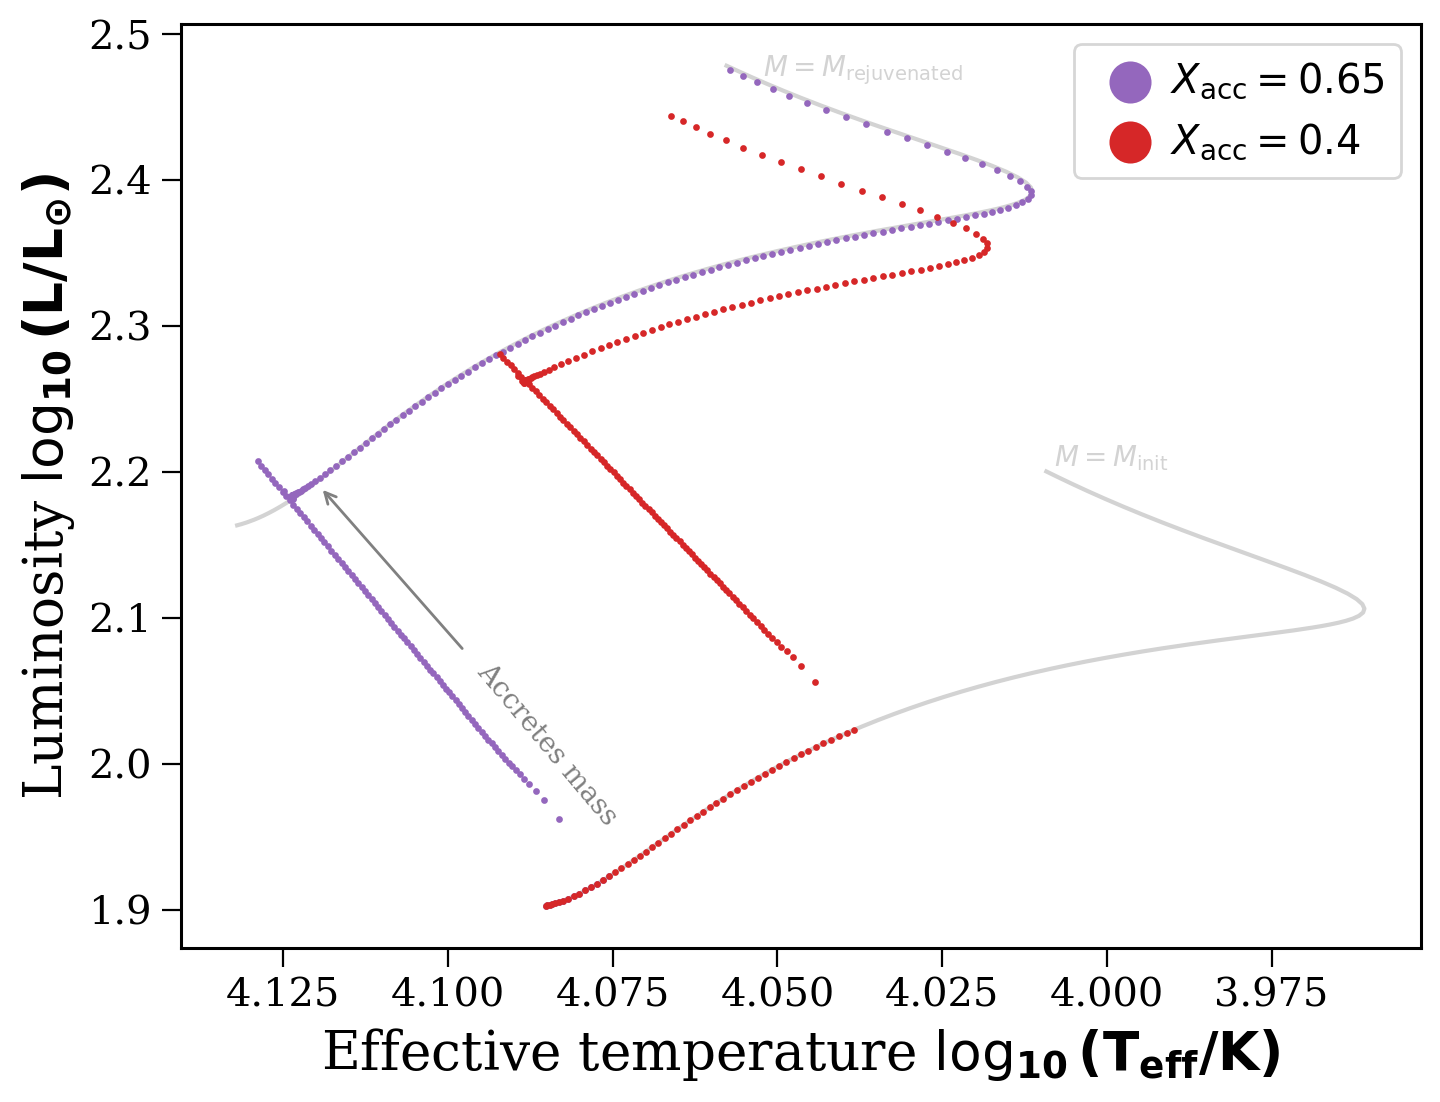

In [12]:
fig, ax = mesaplot.simple_hr(track=tracks[0], show=False, s=0, cbar_var=None)
fig, ax = mesaplot.simple_hr(track=tracks[1], fig=fig, ax=ax, show=False, plot_line=False,
                    s=2, label=r"$X_{\rm acc} = 0.65$", cbar_var=None, color="tab:purple")
fig, ax = mesaplot.simple_hr(track=tracks[2], fig=fig, ax=ax, show=False, s=0, cbar_var=None)
fig, ax = mesaplot.simple_hr(track=tracks[3], fig=fig, ax=ax, show=False, s=2,
                    plot_line=False, cbar_var=None, label=r"$X_{\rm acc} = 0.4$", color="tab:red")

ax.annotate(r"$M = M_{\rm init}$", xy=(0.75, 0.53), ha="center", va="center",
            xycoords="axes fraction", color="lightgrey")
ax.annotate(r"$M = M_{\rm rejuvenated}$", xy=(0.55, 0.95), ha="center", va="center",
            xycoords="axes fraction", color="lightgrey")

ax.legend(markerscale=10, handletextpad=0.0)

ax.annotate("Accretes mass", xy=(0.1115, 0.5), xytext=(0.295, 0.22), xycoords="axes fraction", rotation=-50,
            arrowprops=dict(arrowstyle="->", color="grey"), color="grey", ha="center", va="center")

plt.show()

# $X_H$ profile evolution

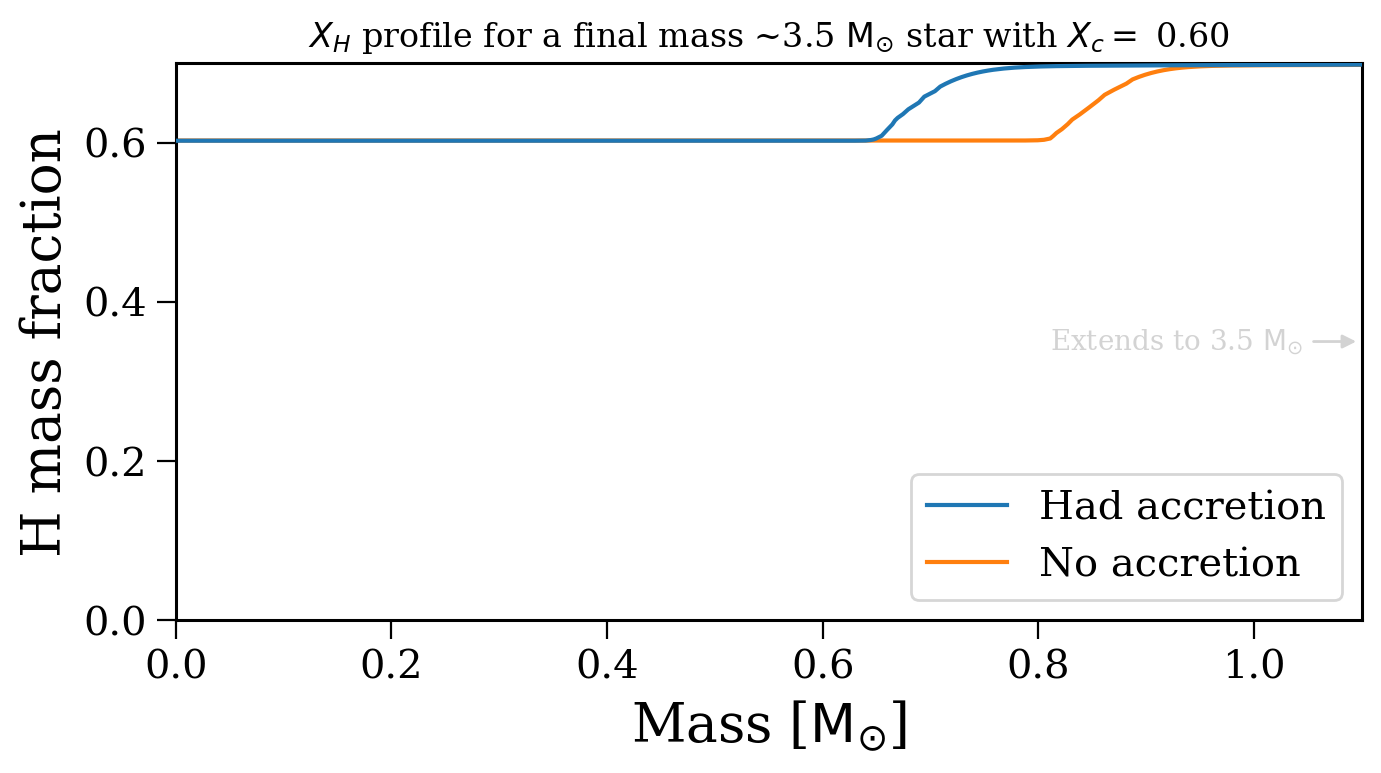

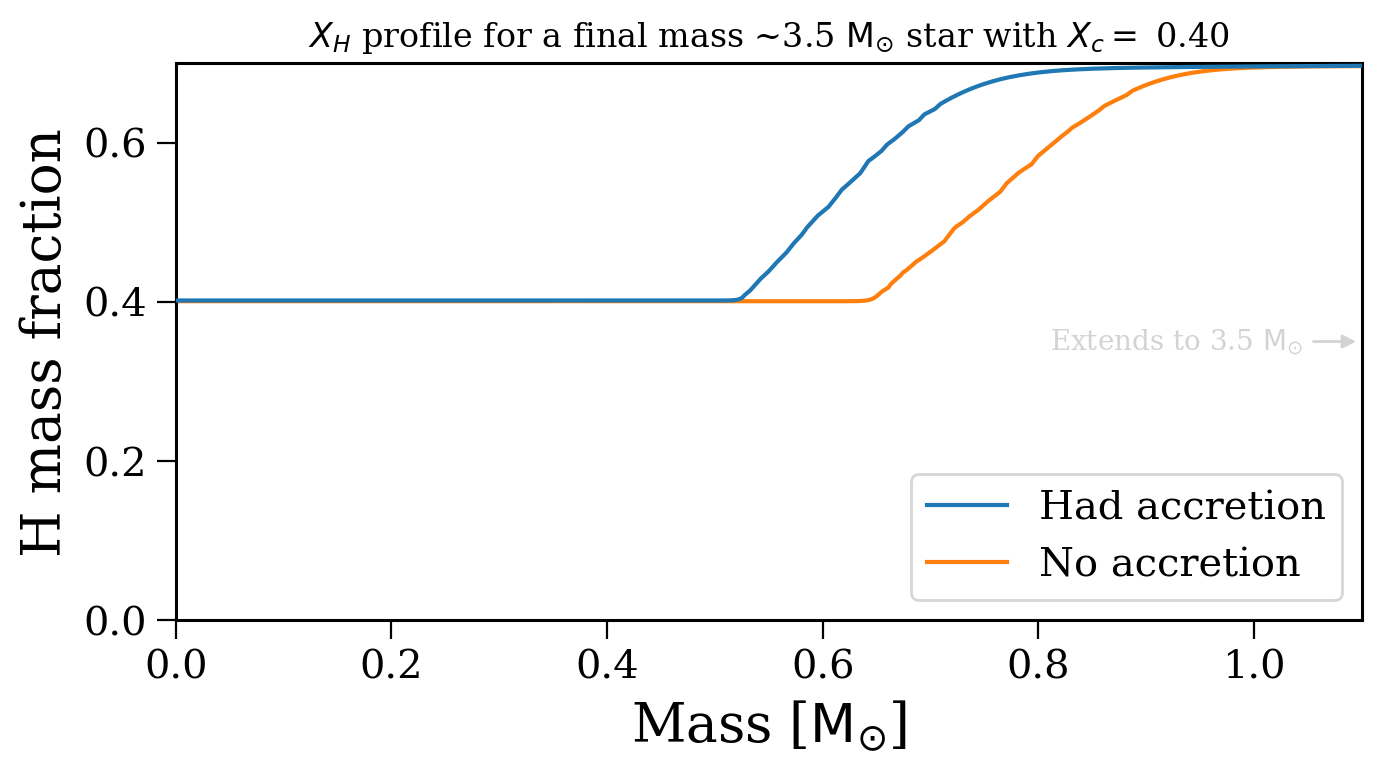

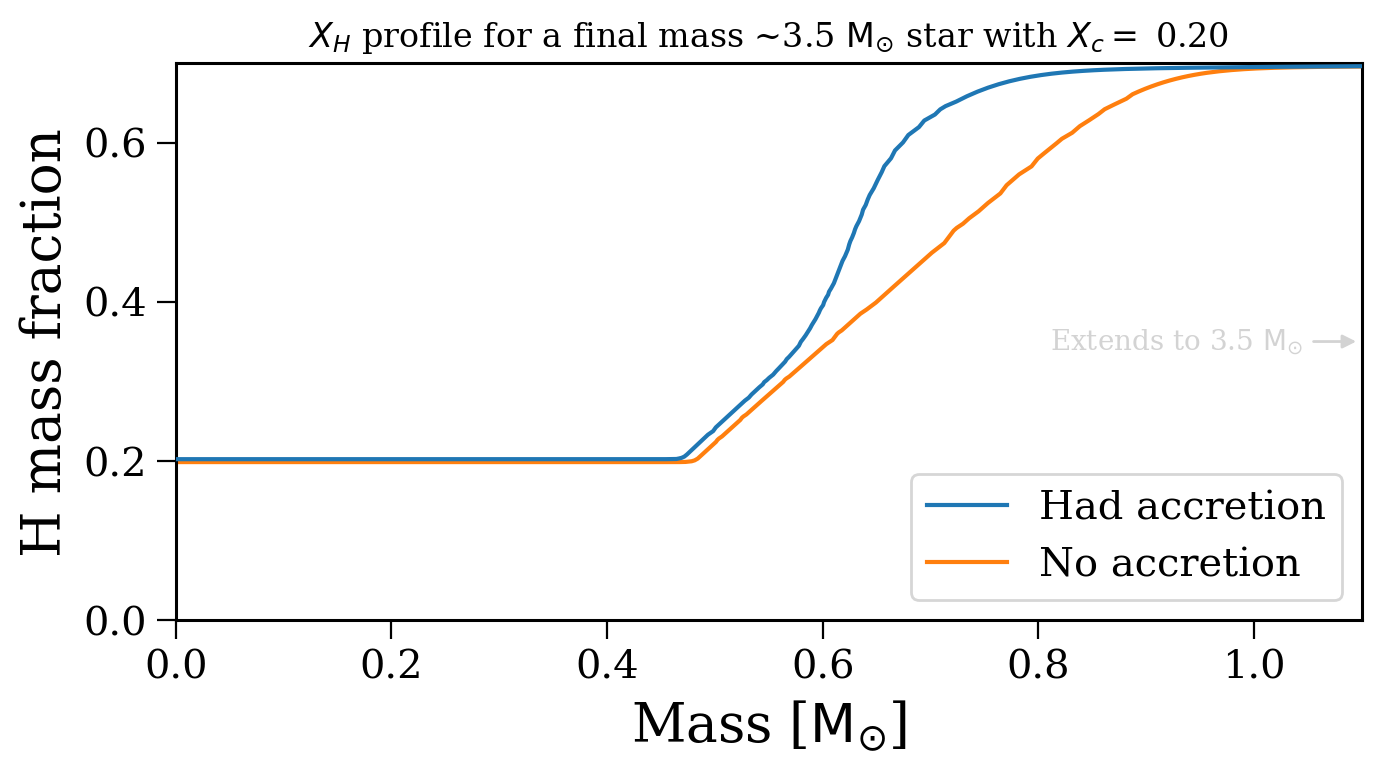

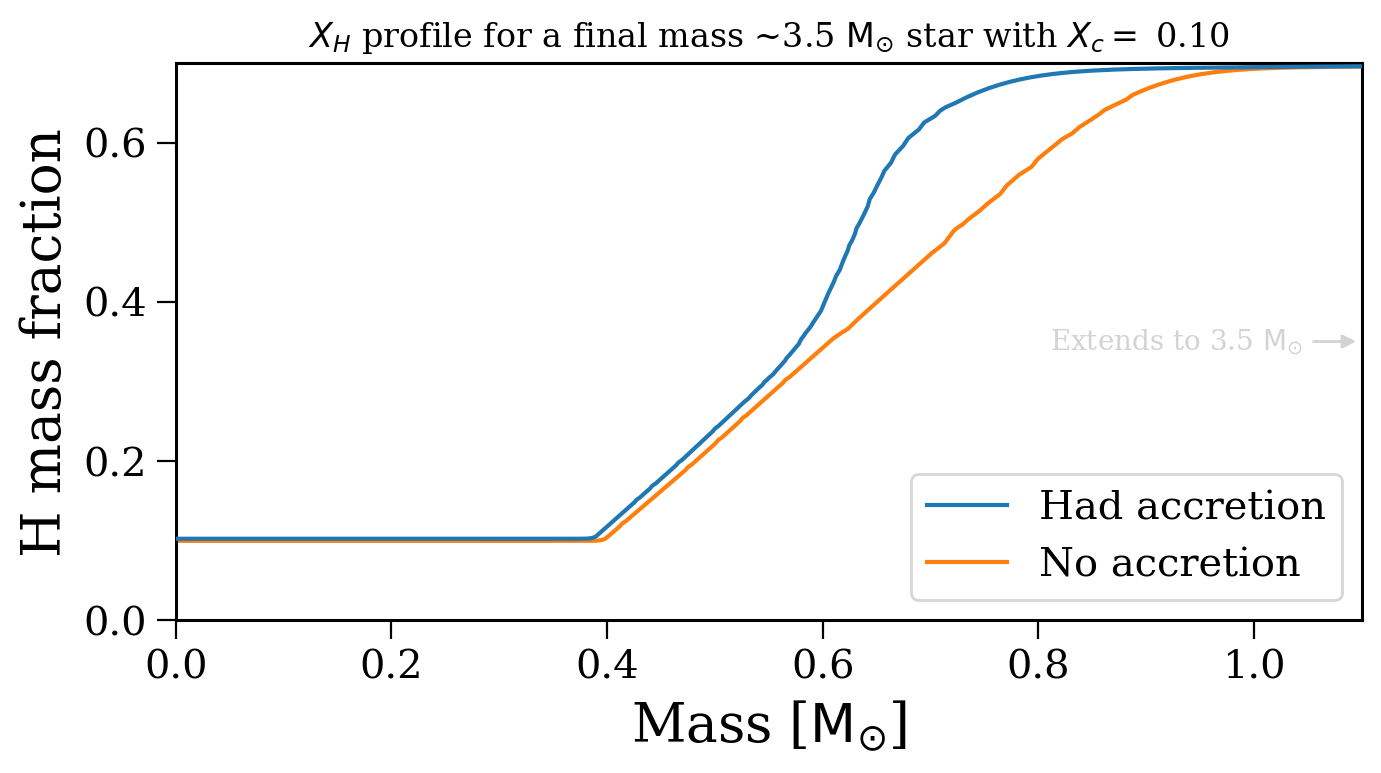

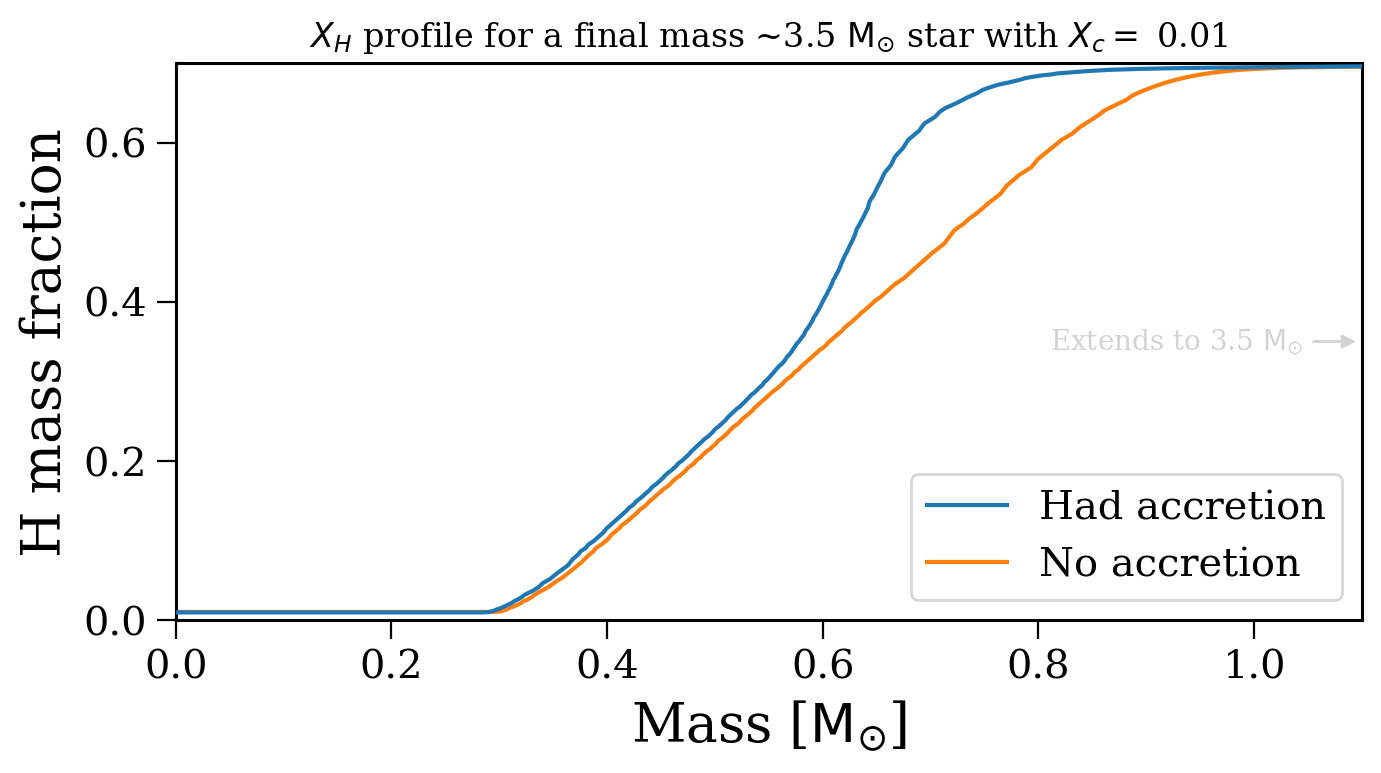

In [139]:
for X_c in [0.6, 0.4, 0.2, 0.1, 0.01]:
    mesaplot.plot_X_H_profile(X_c=X_c, mt_index=0, ref_index=1, tracks=D_mix_tracks)

In [10]:
def get_timesteps(track, start, stop, step, mt_step, delay=0):
    h = track.history
    
    m = h["star_mass"]
    mt_start, mt_end = m[m > m.min()].index[0], m[m == m.max()].index[0]
    age_start = round(h["star_age"].loc[mt_start] / 1e6, 1)
    age_end = round(h["star_age"].loc[mt_end] / 1e6, 1)
    
    t_before = np.arange(start, np.floor(age_start), step)
    t_mt = np.arange(age_start, age_end + mt_step, mt_step)
    t_after = np.arange(np.ceil(age_end), stop + step, step)
    
    t = np.concatenate((t_before, t_mt, t_after))
    
    if delay > 0:
        t = np.concatenate((t, np.repeat(t[-1], delay)))
    return t

10.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0
105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
155.0
160.0
165.0
170.0
175.0
180.0
185.0
190.0
195.0
200.0
205.0
210.0
210.0
210.1
210.2
210.3
210.4
210.5
210.6
210.7
210.8
210.9
211.0
211.1
211.2
211.3
211.4
211.5
211.6
211.7
211.8
211.9
212.0
212.0
217.0
222.0
227.0
232.0
237.0
242.0
247.0
252.0
257.0
262.0
267.0
272.0
277.0
282.0
287.0
292.0
297.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0


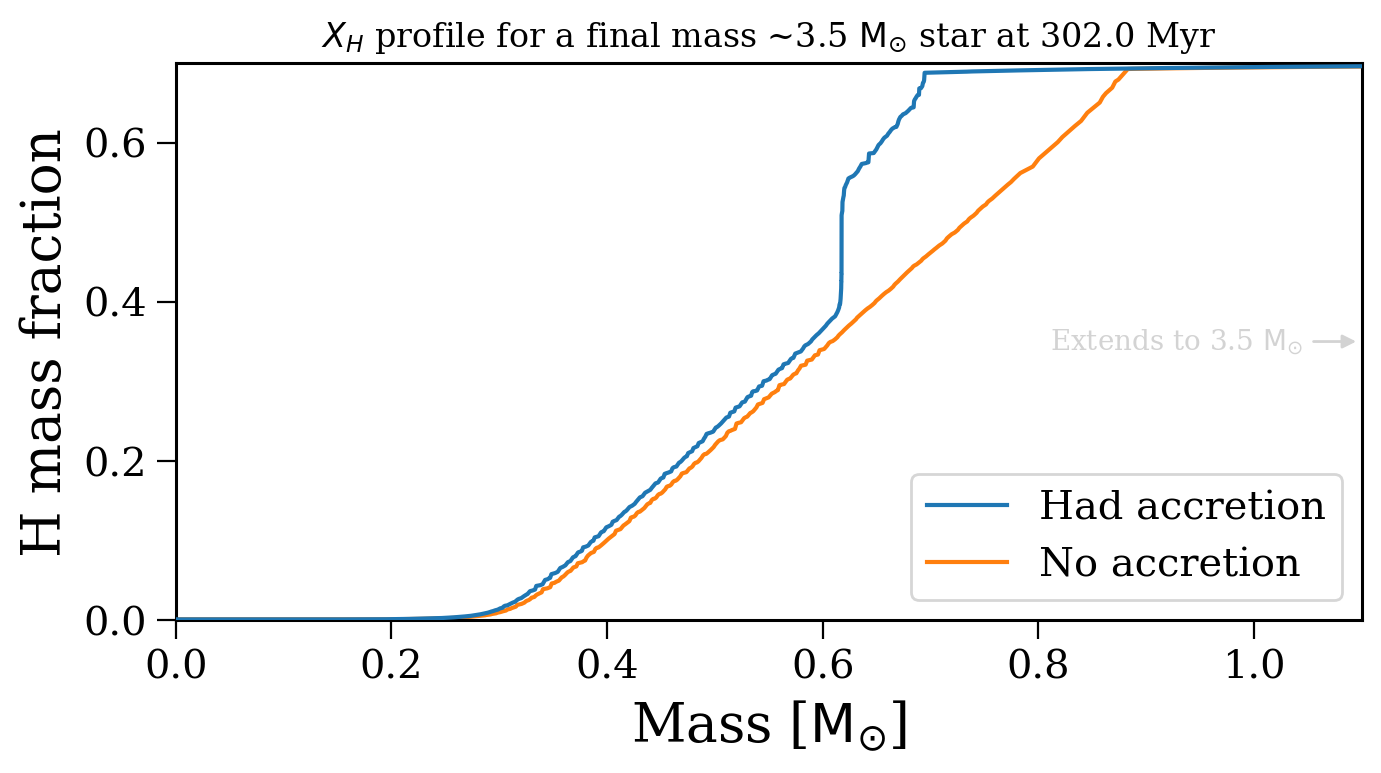

In [385]:
fig, ax = plt.subplots(figsize=(7, 4))
ani = FuncAnimation(fig, plot_X_H_profile,
                    get_timesteps(tracks[3], 10, 300, 5, 0.1, delay=15),
                    fargs=(3, 2, fig, ax, False), repeat=True)

writer = animation.PillowWriter(fps=5,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('X_H_profile_0.4.gif', writer=writer)

plt.show()

# Asteroseismology time woop

In [11]:
D_mix_pairs = [(3, 0.4), (3.508104, 0)]
D_mix_tracks = [mesagrid.Track(f"../output/mass_transfer_grid_with_D_mix/M_{M}-MT_{MT}/",
                       usecols_history=usecols_history,
                       cpus=cpus, parameters=f"M={M}, MT={MT}") for M, MT in D_mix_pairs]

In [12]:
def relevant_model_numbers(track):
    mt_start = track.history[track.history["star_mass"] > 3.0].index[0]
    mt_end = track.history[track.history["star_mass"] >= track.history["star_mass"].max()].index[0]
    
    print(f"Mass transfer starts at model {mt_start} and ends at {mt_end}")

Plotting BV profile for age = 10.0 Myr
Plotting BV profile for age = 10.0 Myr
Plotting BV profile for age = 15.0 Myr
Plotting BV profile for age = 20.0 Myr
Plotting BV profile for age = 25.0 Myr
Plotting BV profile for age = 30.0 Myr
Plotting BV profile for age = 35.0 Myr
Plotting BV profile for age = 40.0 Myr
Plotting BV profile for age = 45.0 Myr
Plotting BV profile for age = 50.0 Myr
Plotting BV profile for age = 55.0 Myr
Plotting BV profile for age = 60.0 Myr
Plotting BV profile for age = 65.0 Myr
Plotting BV profile for age = 70.0 Myr
Plotting BV profile for age = 75.0 Myr
Plotting BV profile for age = 80.0 Myr
Plotting BV profile for age = 85.0 Myr
Plotting BV profile for age = 90.0 Myr
Plotting BV profile for age = 95.0 Myr
Plotting BV profile for age = 100.0 Myr
Plotting BV profile for age = 105.0 Myr
Plotting BV profile for age = 110.0 Myr
Plotting BV profile for age = 115.0 Myr
Plotting BV profile for age = 120.0 Myr
Plotting BV profile for age = 125.0 Myr
Plotting BV profile

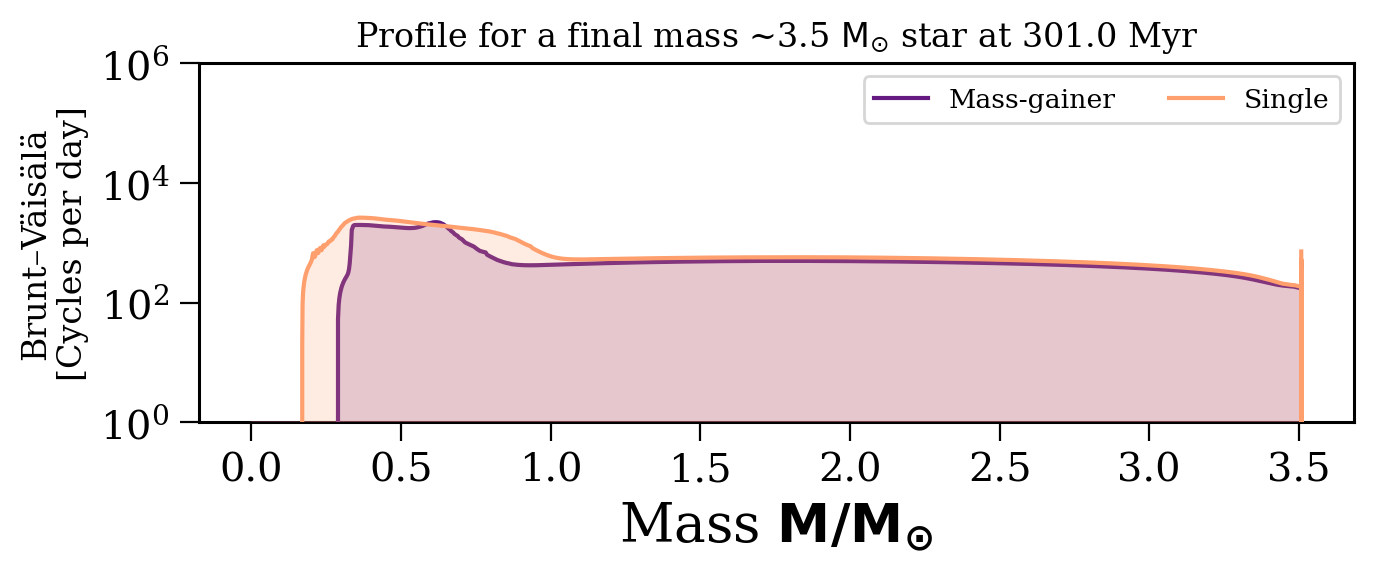

In [37]:
fig, ax = plt.subplots(figsize=(7, 3))
ani = FuncAnimation(fig, mesaplot.plot_BV_profile,
                    get_timesteps(D_mix_tracks[0], 10, 300, 5, 0.1, delay=15),
                    fargs=(None, D_mix_tracks, 0, 1, 1.5, "linear", False, True, fig, ax, False), repeat=True)

writer = animation.PillowWriter(fps=5,
                                bitrate=1800)
ani.save('BV_profile_0.4_D_mix.gif', writer=writer, dpi=300)

plt.show()

Plotting BV profile for X_c = 0.1


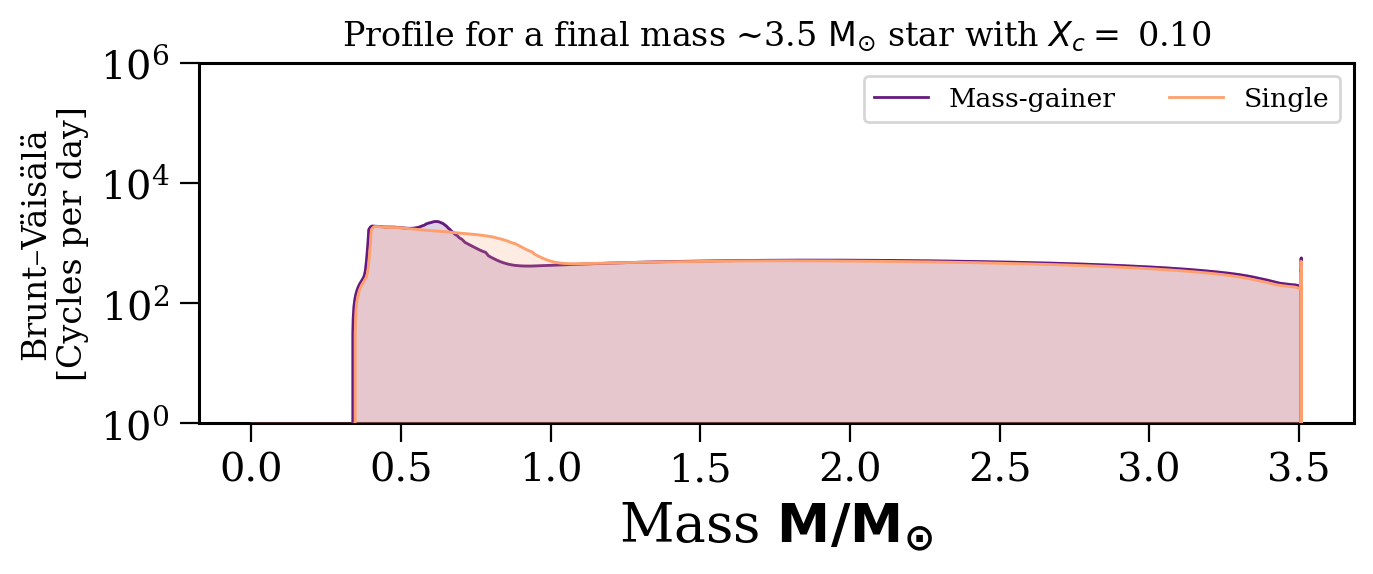

(<Figure size 700x300 with 1 Axes>,
 <Axes: title={'center': 'Profile for a final mass ~3.5 $\\rm M_{\\odot}$ star with $X_c =$ 0.10'}, xlabel='Mass $\\mathbf{M/M_{\\odot}}$', ylabel='Brunt–Väisälä\n[Cycles per day]'>)

In [143]:
mesaplot.plot_BV_profile(X_c=0.1, mt_index=0, ref_index=1, tracks=D_mix_tracks)

Parsing M=3, MT=0.4
305.24980561323446
Parsing M=3.508104, MT=0
225.31658317957135


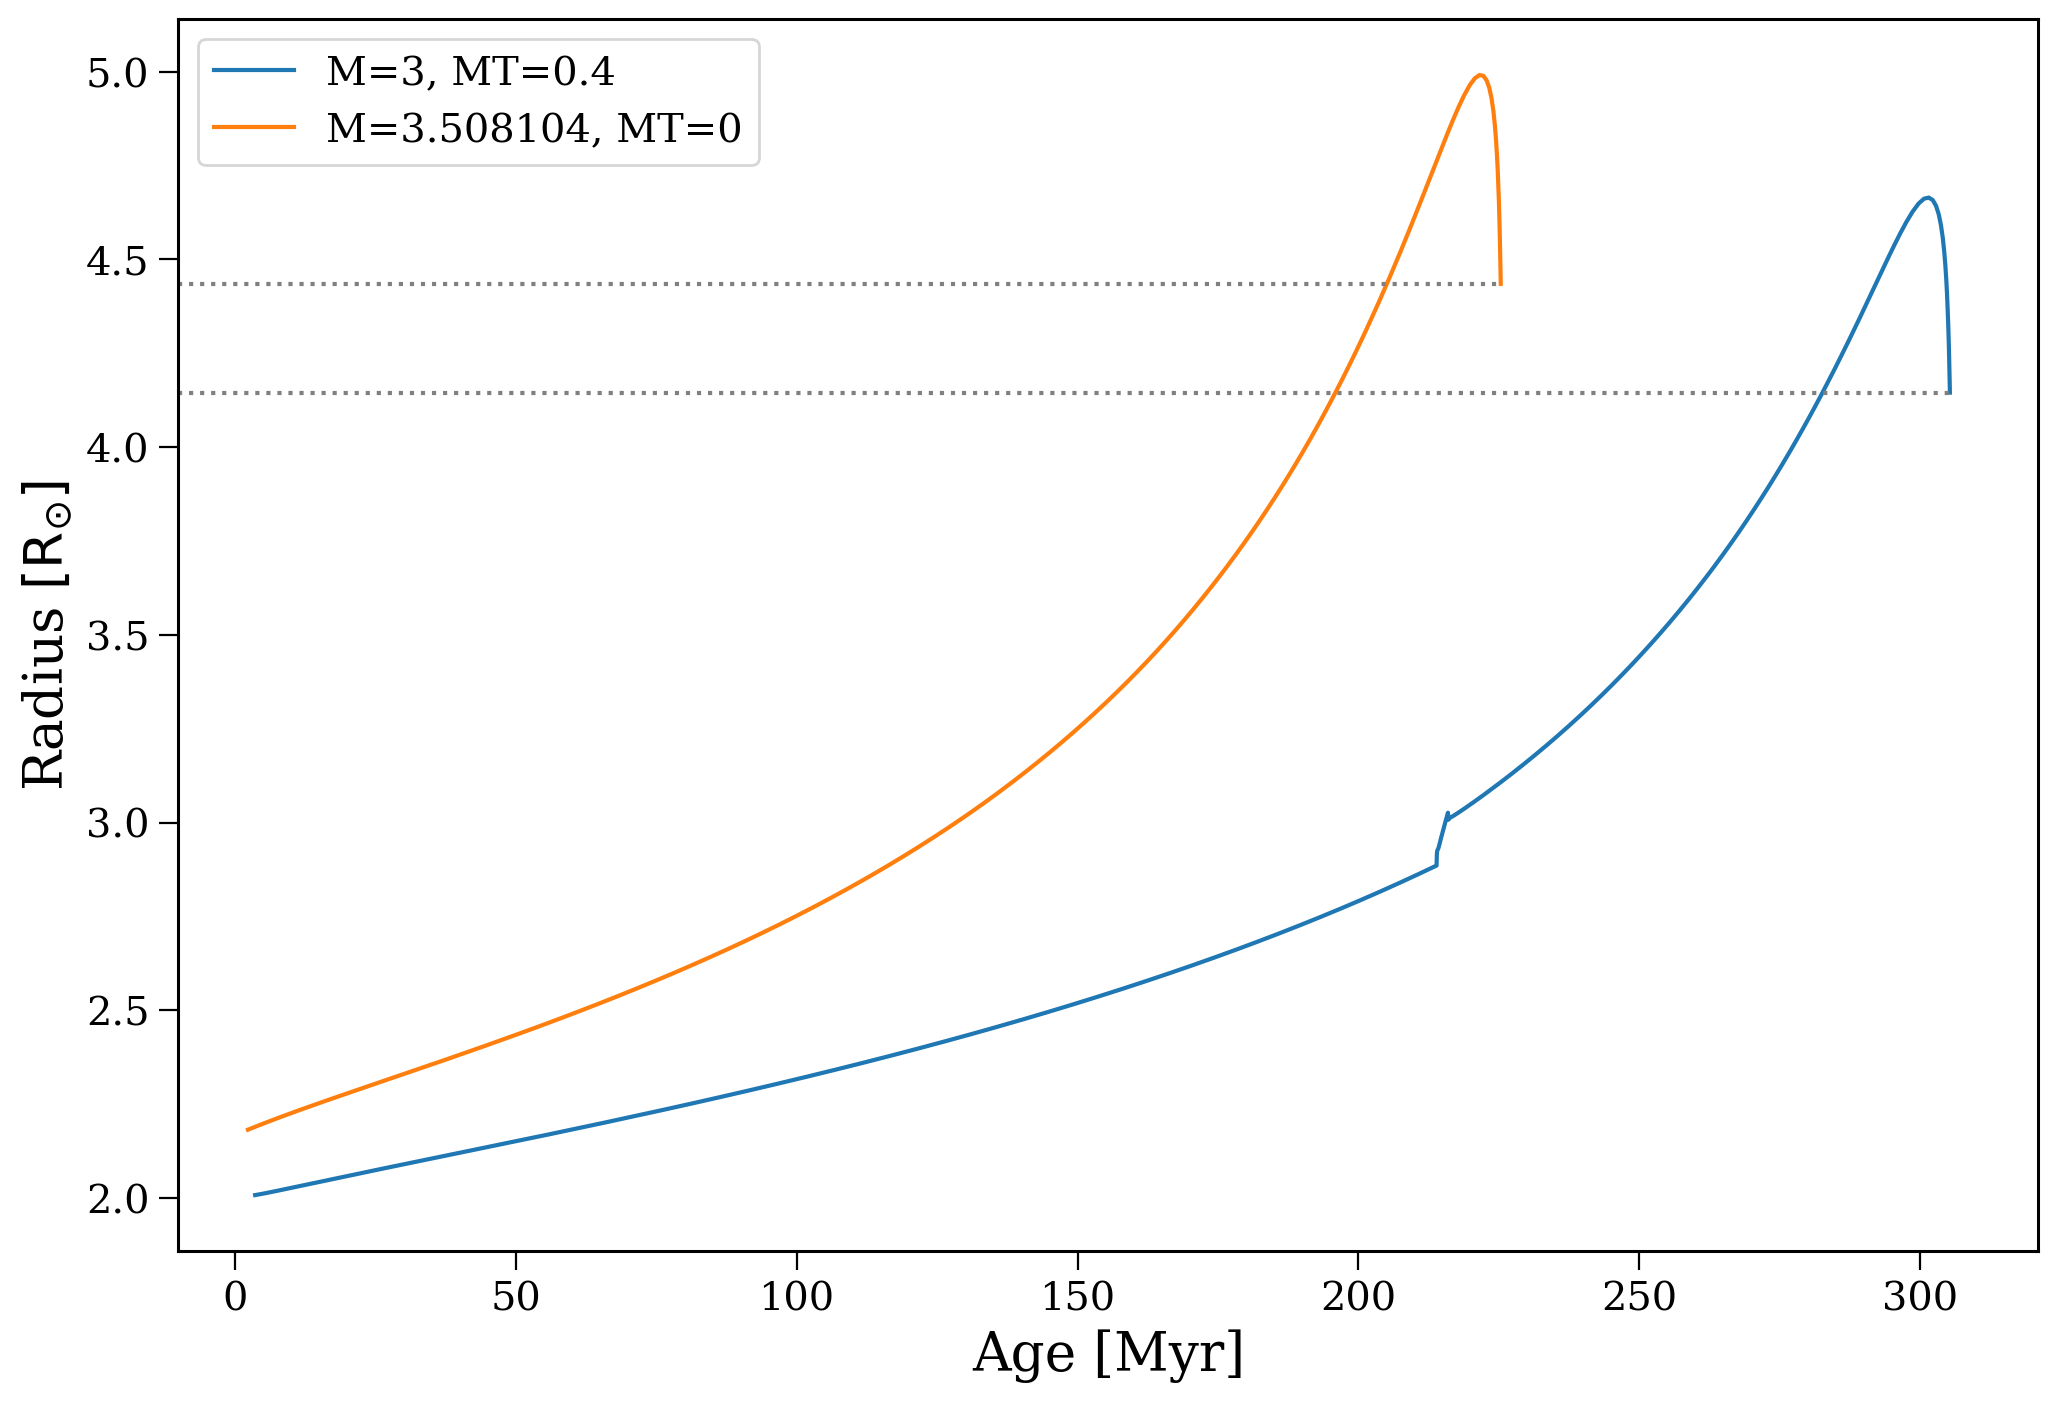

In [88]:
fig, ax = plt.subplots()

for i in range(len(D_mix_tracks)):
    h = D_mix_tracks[i].history[D_mix_tracks[i].history["center_h1"] < 0.995 * D_mix_tracks[i].history["center_h1"].max()]
    ax.plot(h["star_age"] / 1e6, get_radius(h), label=D_mix_tracks[i].parameters)
    print(h["star_age"].iloc[-1] / 1e6)
    ax.plot([-10, h["star_age"].iloc[-1] / 1e6], [get_radius(h)[-1].value, get_radius(h)[-1].value],
            color="grey", linestyle="dotted")
    
ax.set_xlim(left=-10)
    
ax.legend()
ax.set_xlabel("Age [Myr]")
ax.set_ylabel(r"Radius $[\rm R_{\odot}]$")
plt.show()

In [39]:
def period_spacing_plot_by_prof_num(track, profile_number, x_var="period", label_modes=False,
                        xlims=None, ylims=None,
                        fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))

    age = track.history.loc[profile_number - 1]["star_age"] / 1e6
    X_c = track.history.loc[profile_number - 1]["center_h1"]
    # print(f"Age={age:1.2f} Myr")
        
    df = track.freqs[profile_number - 1]
    # df = df[(df["l"] == 1) & (df["m"] == 0) & (df["n_p"] == 0)]
    df = df.loc[( (df["l"] == 1) & (df["m"] == 0) & (df["n_p"] == 0) ) ]
    periods = 1 / df["Re(freq)"].values * u.day
    ng = df["n_g"].values
    delta_p  = periods[:-1] - periods[1:]
    
    x_vals = periods if x_var == "period" else -ng
    
    if label_modes:
        ax.plot(x_vals[:-1], delta_p, label="Measured periods")
    else:
        ax.plot(x_vals[:-1], delta_p, marker="o", label="Measured periods")
        
    if label_modes:
        for i in range(len(delta_p)):
            ax.annotate(ng[i], xy=(x_vals[i], delta_p[i]), ha="center", va="center",
                        fontsize=0.25*fs, color="grey", bbox=dict(boxstyle="circle", facecolor="white", ec="tab:blue"))

    ax.set_xlabel(r"Period, $P \, [\rm days]$" if x_var == "period" else r"$k$ (g-modes)")
    ax.set_ylabel(r"$\Delta P \, [\rm days]$")
    
    ax.set_title(f"\nAge = {age:1.1f} Myr, X_c = {X_c:1.2f}", fontsize=0.6*fs)
    
    ax.annotate(r"$(l = 1, m = 0)$ g modes", xy=(0.02, 0.02), xycoords="axes fraction", va="bottom")
    
    aps = asymptotic_period_spacing(track.profiles[profile_number - 1]).to(u.day).value
    ax.axhline(aps, color="lightgrey", linestyle="dotted", zorder=-1, label="Expected asymptotic spacing")
    
    if ylims is not None:
        if ylims == "auto":
            ax.set_ylim(aps - 0.04, aps + 0.04)
        else:
            ax.set_ylim(ylims)
            
    if xlims is not None:
        ax.set_xlim(xlims)
    
    ax.legend(loc="upper left", fontsize=0.5 * fs)
    
    if show:
        plt.show()

    return fig, ax, ng, periods

In [13]:
def plot_period_spacing(age=None, X_c=None, mt_track=None, ref_track=None,
                        x_var="period", label_modes=False, xlims=None, ylims=None,
                        fig=None, ax=None, show=True):
    if age is None and X_c is None:
        raise ValueError("At least one of `age` or `X_c` must not be None")
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 3))
    plt.cla()
    

    if X_c is None:
        print(f"Plotting period spacing for age = {age:1.1f} Myr")
        acc_mod = np.abs(mt_track.history["star_age"] / 1e6 - age).argmin() if mt_track is not None else None
        non_acc_mod = np.abs(ref_track.history["star_age"] / 1e6 - age).argmin() if ref_track is not None else None
    else:
        print(f"Plotting period spacing for X_c = {X_c:1.2f}")
        acc_mod = np.abs(mt_track.history["center_h1"] - X_c).argmin() if mt_track is not None else None
        non_acc_mod = np.abs(ref_track.history["center_h1"] - X_c).argmin() if ref_track is not None else None
    
    print(acc_mod, non_acc_mod)
    
    for mod, track, tag, col in zip([acc_mod, non_acc_mod],
                                    [mt_track, ref_track],
                                    ["Mass-gainer", "Single"],
                                    [plt.get_cmap("magma")(0.3), plt.get_cmap("magma")(0.8)]):
        
        if track is None:
            continue

    # age = track.history.loc[profile_number - 1]["star_age"] / 1e6
    # X_c = track.history.loc[profile_number - 1]["center_h1"]
    # print(f"Age={age:1.2f} Myr")
        
        df = track.freqs[mod - 1]
        df = df[(df["l"] == 1) & (df["m"] == 0)]# & (df["n_p"] == 0)]
        mixed_modes = df[df["n_p"] > 0]
        duplicates = df[df["n_g"].isin(mixed_modes["n_g"])]
        drop_these = duplicates[duplicates["n_p"] == 0].index

        df = df.drop(index=drop_these)
                
        periods = 1 / df["Re(freq)"].values * u.day
        ng = df["n_g"].values
        delta_p  = periods[:-1] - periods[1:]

        x_vals = periods if x_var == "period" else -ng
    
        if label_modes:
            ax.plot(x_vals[:-1], delta_p, label=tag, color=col)
        else:
            ax.plot(x_vals[:-1], delta_p, marker="o", label=tag, color=col)

        if label_modes:
            for i in range(len(delta_p)):
                ax.annotate(ng[i], xy=(x_vals[i], delta_p[i]), ha="center", va="center",
                            fontsize=0.25*fs, color="grey",
                            bbox=dict(boxstyle="circle", facecolor="white", ec=col))

        aps = asymptotic_period_spacing(track.profiles[mod - 1]).to(u.day).value
        ax.axhline(aps, color=col, alpha=0.5, linestyle="dotted", zorder=-1)#, label=f"Expected asymptotic spacing ({tag})")

    ax.set_xlabel(r"Period, $P \, [\rm days]$" if x_var == "period" else r"$k$ (g-modes)")
    ax.set_ylabel(r"$\Delta P \, [\rm days]$")

    # ax.set_title(f"\nAge = {age:1.1f} Myr, X_c = {X_c:1.2f}", fontsize=0.6*fs)
    
    ax.set_title(r"Period spacing for final mass ~3.5 $\rm M_{\odot}$ star"\
                     + (f' at {age:1.1f} Myr' if X_c is None else r" with $X_c =$" + f' {X_c:1.2f}'))

    ax.annotate(r"$(l = 1, m = 0)$ g modes", xy=(0.02, 0.02), xycoords="axes fraction", va="bottom")

    if ylims is not None:
        if ylims == "auto":
            ax.set_ylim(aps - 0.04, aps + 0.04)
        else:
            ax.set_ylim(ylims)

    if xlims is not None:
        ax.set_xlim(xlims)

    ax.legend(loc="upper left", fontsize=0.5 * fs)
    
    if show:
        plt.show()

    return fig, ax, ng, periods

In [14]:
test_track = mesagrid.Track(f"../output/mass_transfer_grid_with_D_mix/M_{3.508104}-MT_{0}/",
                       usecols_history=usecols_history,
                       cpus=cpus)

In [15]:
def find_closest_model_number(track, age=None, X_c=None):
    if age is None and X_c is None:
        raise ValueError("At least one of `age` or `X_c` must not be None")

    if X_c is None:
        mod = np.abs(track.history["star_age"] / 1e6 - age).argmin()
    else:
        mod = np.abs(track.history["center_h1"] - X_c).argmin()
        
    return mod

In [17]:
for X_c in [0.65, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01]:
    print(find_closest_model_number(test_track, X_c=X_c), end=", ")

53, 76, 90, 106, 123, 141, 158, 

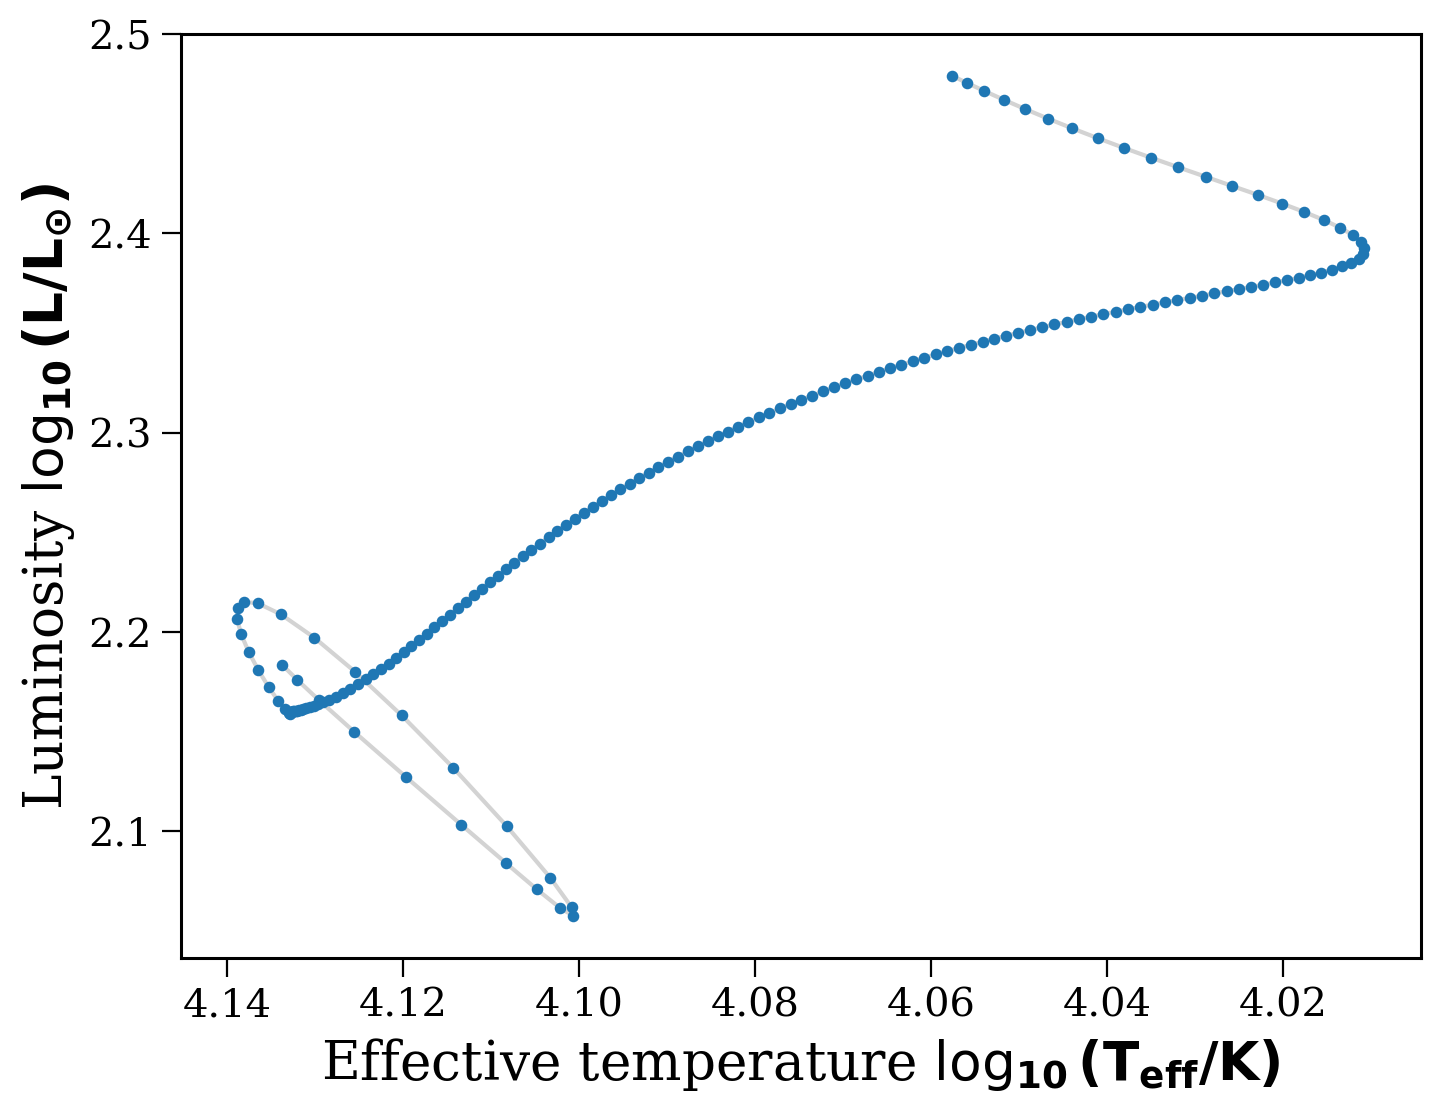

In [45]:
fig, ax = mesaplot.simple_hr(test_track, trim_pre_ms=False, cbar_var=None)

In [18]:
def asymptotic_period_spacing(p, unit=u.day):
    l = 1
    L = np.sqrt(l * (l + 1))
    
    p_sort = p.sort_values(by="logR")

    R = 10**(p_sort["logR"].values)
    r = R / np.max(R)
    N = p_sort["brunt_N"].values
    
    delta_P = 2 * np.pi**2 / (L * np.trapz(y=N / r, x=r)) * u.s
    return delta_P.to(unit)

In [78]:
interact(lambda X_c: plot_period_spacing(X_c=X_c, mt_track=D_mix_tracks[0], ref_track=D_mix_tracks[1], ylims="auto"),
         X_c=FloatSlider(value=0.7, min=0.001, max=0.7, step=0.01))

interactive(children=(FloatSlider(value=0.7, description='X_c', max=0.7, min=0.001, step=0.01), Output()), _do…

<function __main__.<lambda>(X_c)>

In [19]:
def create_GYRE_bash(mods, procs=6):
    mods_strings = [f"profile{mod}.data.GYRE" for mod in mods]
    return "echo -n '" + ','.join(mods_strings) + "' | xargs -d ',' -P " + str(min(procs, len(mods_strings)))\
        + " -I {} ~/Documents/research/kavli-2023/algol-seismology/gyre6freqs.sh -i {} -t 1 -e"

In [109]:
create_GYRE_bash([find_closest_model_number(D_mix_tracks[0], X_c=X_c)
                  for X_c in [0.68, 0.5, 0.35, 0.25, 0.1]])

"echo -n 'profile33.data.GYRE,profile62.data.GYRE,profile198.data.GYRE,profile213.data.GYRE,profile238.data.GYRE' | xargs -d ',' -P 5 -I {} ~/Documents/research/kavli-2023/algol-seismology/gyre6freqs.sh -i {} -t 1 -e"

In [111]:
create_GYRE_bash([find_closest_model_number(D_mix_tracks[1], X_c=X_c)
                  for X_c in [0.68, 0.5, 0.35, 0.25, 0.1]])

"echo -n 'profile47.data.GYRE,profile76.data.GYRE,profile98.data.GYRE,profile114.data.GYRE,profile141.data.GYRE' | xargs -d ',' -P 5 -I {} ~/Documents/research/kavli-2023/algol-seismology/gyre6freqs.sh -i {} -t 1 -e"

Plotting period spacing for X_c = 0.68
33 47


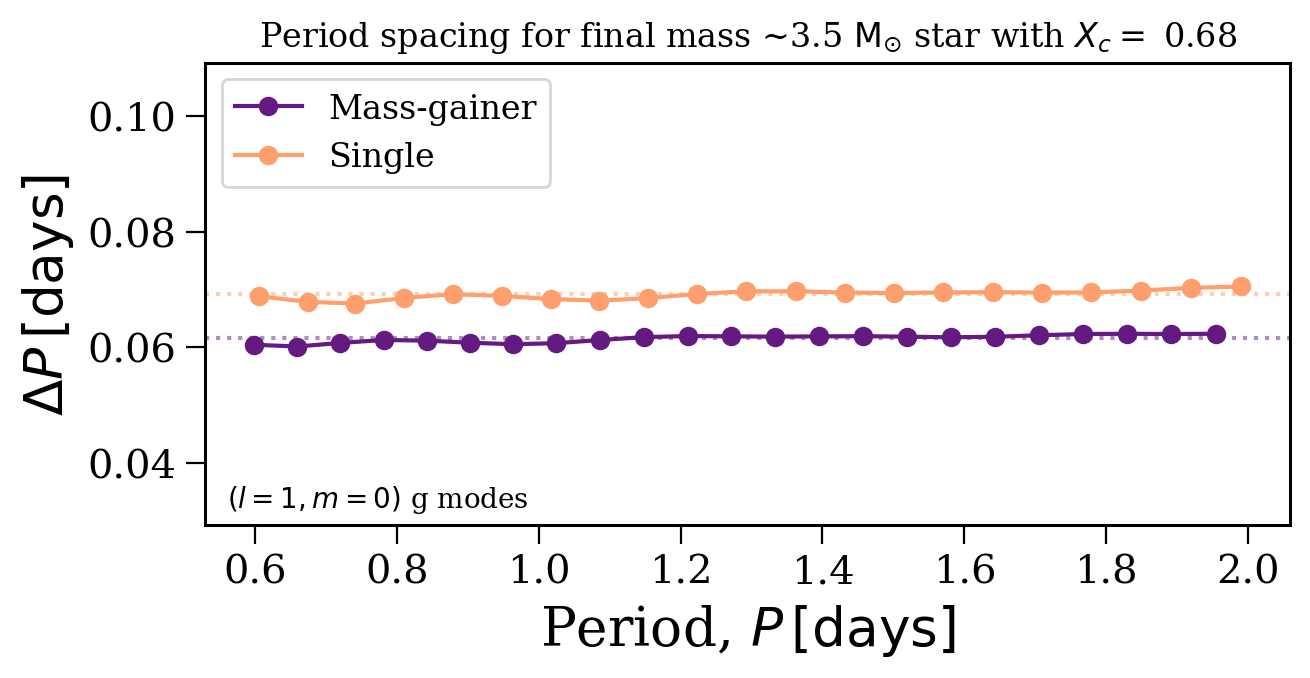

Plotting period spacing for X_c = 0.50
62 76


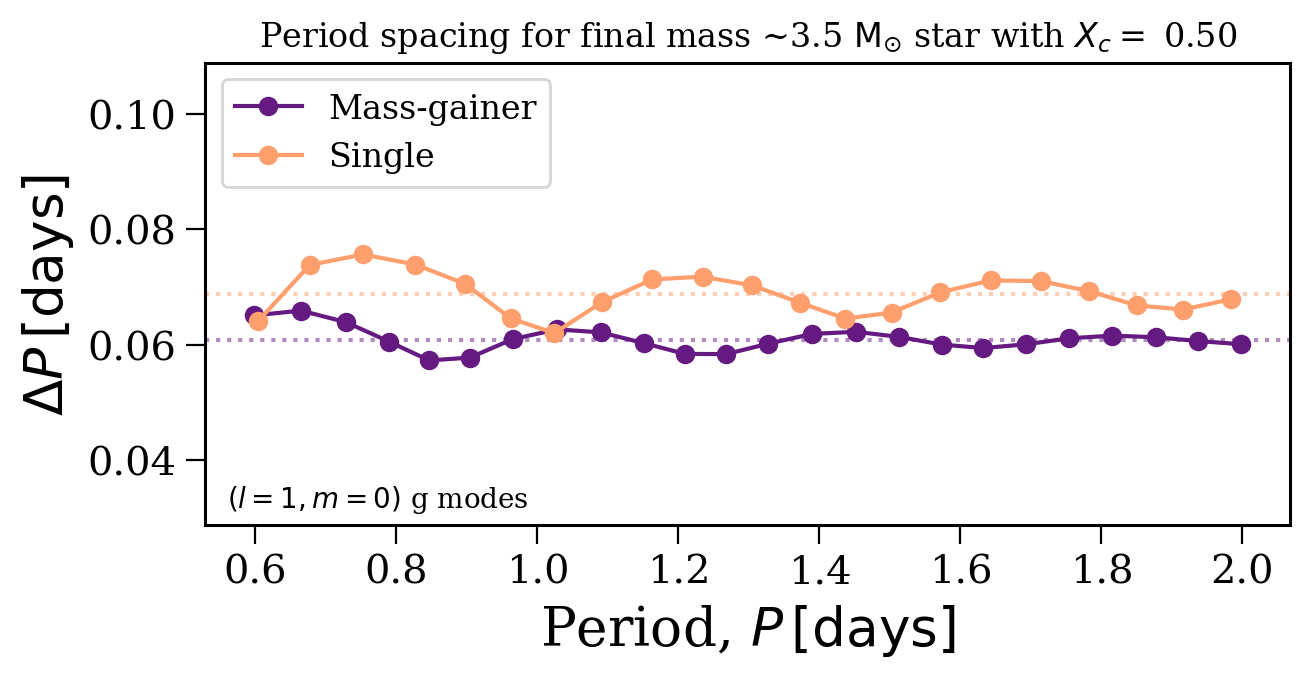

Plotting period spacing for X_c = 0.35
198 98


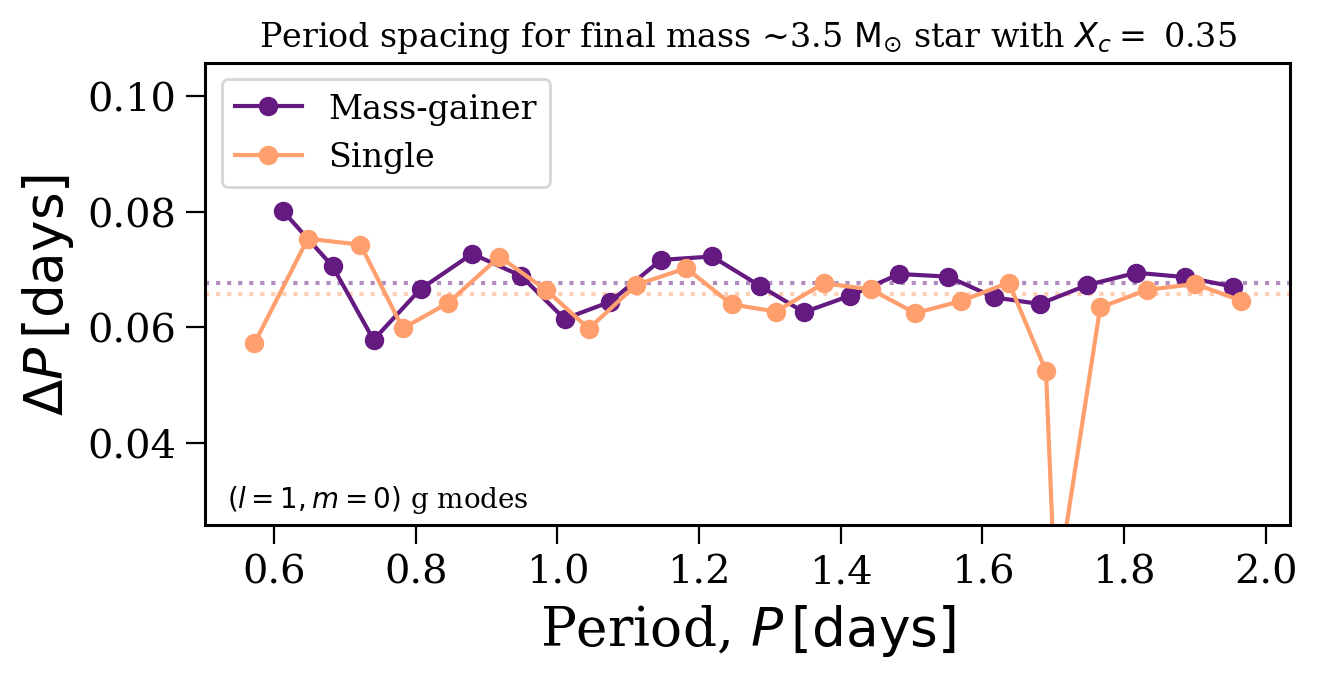

Plotting period spacing for X_c = 0.25
213 114


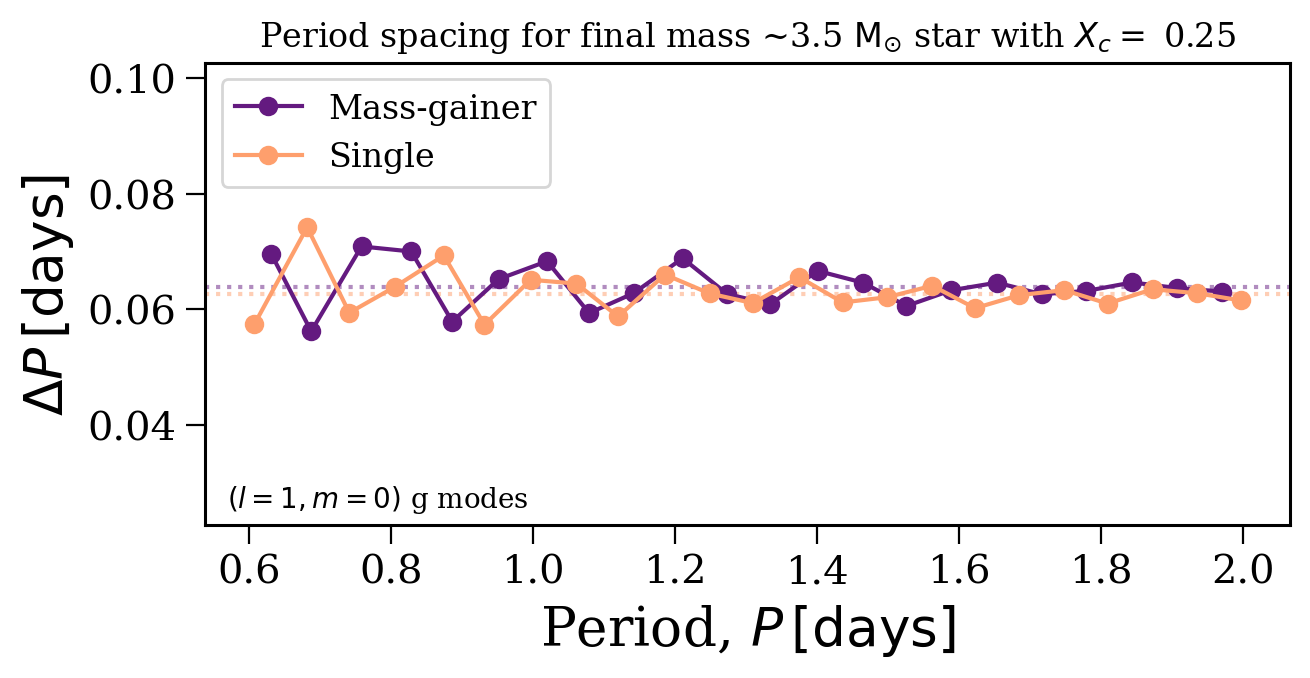

Plotting period spacing for X_c = 0.10
238 141


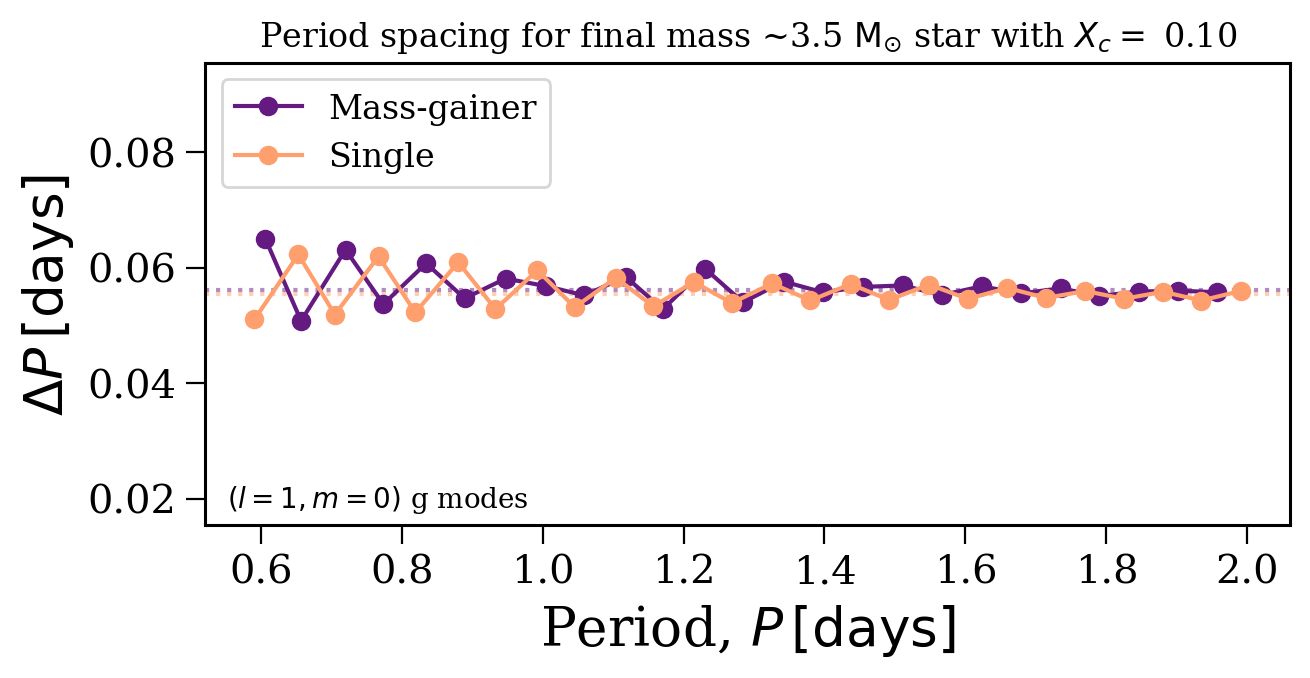

In [21]:
for X_c in [0.68, 0.5, 0.35, 0.25, 0.1]:
    plot_period_spacing(X_c=X_c, mt_track=D_mix_tracks[0], ref_track=D_mix_tracks[1], ylims="auto")

# Eigenfunctions

In [22]:
def get_eigenfunctions(track, profile_number):
    eig_dir = os.path.join(track.dir, 'profile' + str(profile_number) + '-freqs')
    eigs = {}
    for fname in os.listdir(eig_dir):
        if fname[:2] != '00':
            continue
        eig_i = pd.read_table(os.path.join(eig_dir, fname), sep='\s+', skiprows=5)
        sph_deg, rad_ord = fname.split('_')
        eigs[(int(sph_deg), 'x')] = eig_i['x']
        eigs[(int(sph_deg), int(rad_ord))] = eig_i[['Re(xi_r)', 'Re(xi_h)']]
    return eigs

Plotting period spacing for X_c = 0.35
None 98


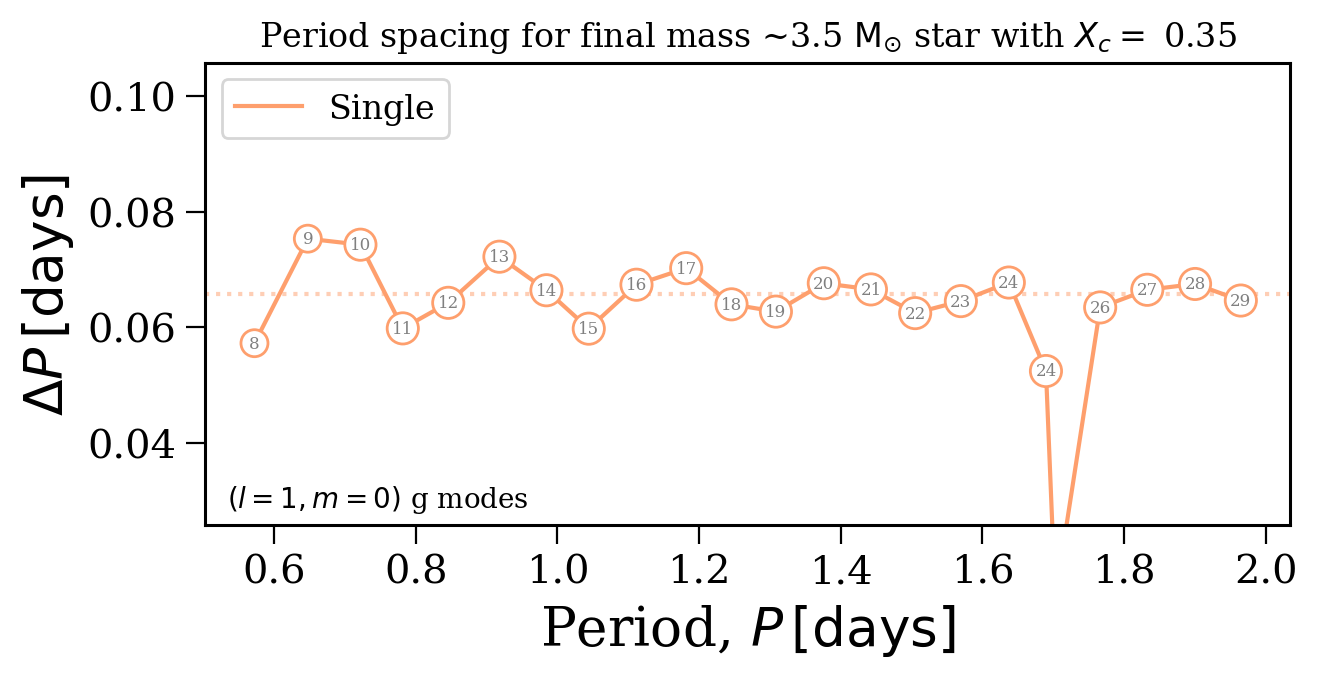

In [137]:
plot_period_spacing(X_c=0.35, ref_track=D_mix_tracks[1], mt_track=None,
                    ylims="auto", label_modes=True);

In [23]:
def plot_eigs(track, mod, sph_deg, rad_ord, show=True):
    
    fig, ax = plt.subplots(figsize=(9, 4))
    
    eigs = get_eigenfunctions(track, mod)
    
    x   = eigs[(sph_deg, 'x')]
    eig = eigs[(sph_deg, rad_ord)]
    
    ax.plot(x, eig['Re(xi_r)'], label='radial',     lw=2, zorder=11)
    ax.plot(x, eig['Re(xi_h)'], label='horizontal', lw=2, zorder=10)
    
    ax.set_xlim([0, 1])
    ax.set_ylim([-20, 20])
    
    core = core_boundary(track, mod)
    ax.axvspan(0, core, ls='dotted', color="lightgrey", alpha=0.5)
    ax.axvline(core, ls='dotted', color="lightgrey")
    ax.annotate("Convective\nCore", xy=(core / 2, ax.get_ylim()[-1] * 0.9), ha="center", va="top", color="grey")
    
    ax.set_xlabel(r'Fractional radius $r/R$')
    ax.set_ylabel('Normalized\neigenfunction ' + r'$\xi$')
    
    ax.axhline(0, ls='dotted', color="lightgrey")
    
    X_c = track.history.loc[mod - 1]["center_h1"]
    ax.set_title(r'Eigenfunctions at $X_c=$' + f'{X_c:1.3f} ' + r'($\ell = $' + f'{sph_deg}, ' + r'$n = $' + f'{rad_ord})')
    ax.legend(loc='lower left')

    if show:
        plt.show()
    
    return fig, ax

In [24]:
def core_boundary(track, mod):
    p = track.profiles[mod - 1]
    logR_core = p[p["x_mass_fraction_H"] > p["x_mass_fraction_H"].min() * 1.01]["logR"].iloc[-1]
    logR_edge = p["logR"].iloc[0]
    
    return 10**(logR_core) / 10**(logR_edge)

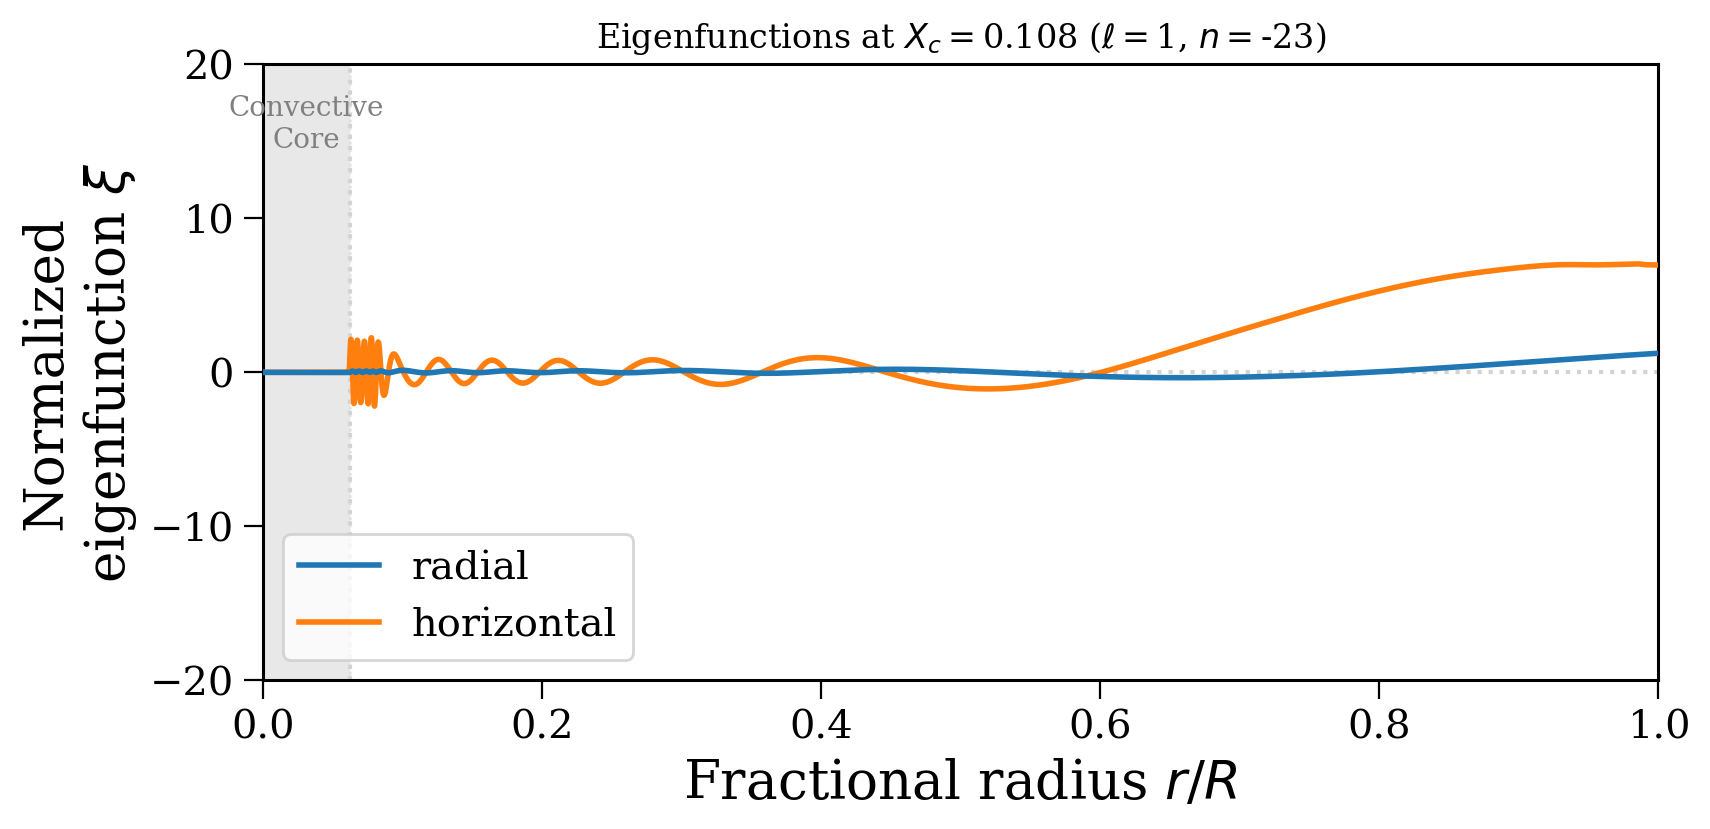

(<Figure size 900x400 with 1 Axes>,
 <Axes: title={'center': 'Eigenfunctions at $X_c=$0.108 ($\\ell = $1, $n = $-23)'}, xlabel='Fractional radius $r/R$', ylabel='Normalized\neigenfunction $\\xi$'>)

In [140]:
plot_eigs(D_mix_tracks[0], 238, 1, -23)

In [231]:
interact(lambda n: plot_eigs(D_mix_tracks[0], 39, 1, -n), n=IntSlider(10, 9, 31))

interactive(children=(IntSlider(value=10, description='n', max=31, min=9), Output()), _dom_classes=('widget-in…

<function __main__.<lambda>(n)>

# What if...

In [69]:
df = D_mix_tracks[0].freqs[47 - 1]
df = df[(df["l"] == 1) & (df["m"] == 0)]# & (df["n_p"] == 0)]

mixed_modes = df[df["n_p"] > 0]
duplicates = df[df["n_g"].isin(mixed_modes["n_g"])]
drop_these = duplicates[duplicates["n_p"] == 0].index

df = df.drop(index=drop_these)

In [145]:
find_closest_model_number(D_mix_tracks[0], X_c=0.1), find_closest_model_number(D_mix_tracks[1], X_c=0.1)

(238, 141)

(0.02180760708600584, 0.10180760708600584)

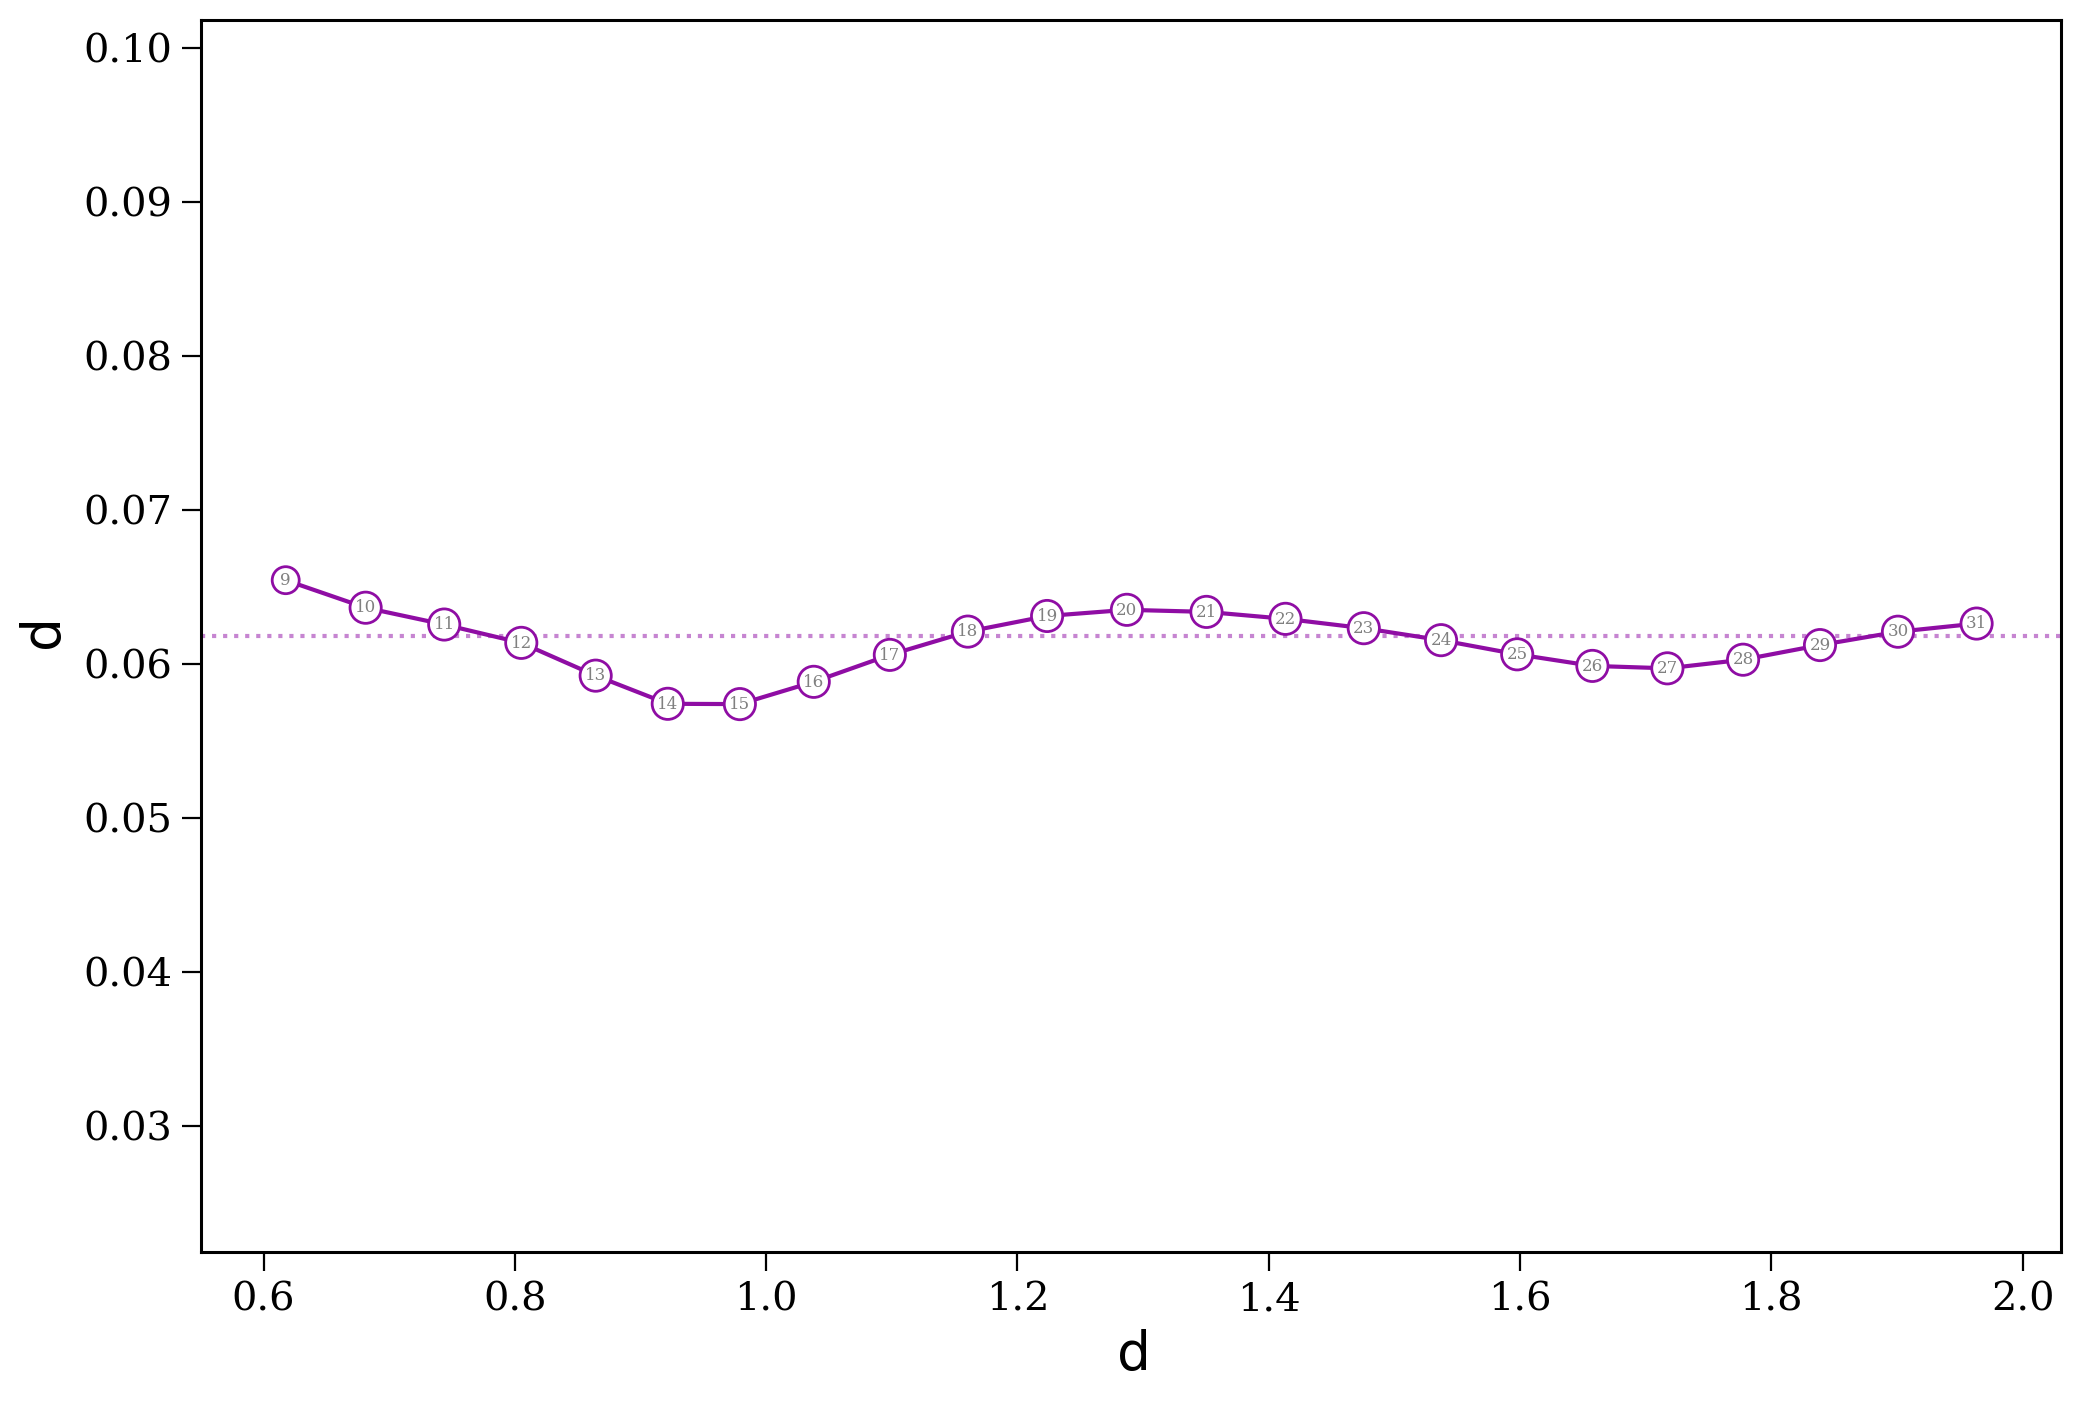

In [70]:
periods = 1 / df["Re(freq)"].values * u.day
ng = df["n_g"].values
delta_p  = periods[:-1] - periods[1:]

x_vals = periods#if x_var == "period" else -ng

col = plt.get_cmap("plasma")(0.3)
plt.plot(x_vals[:-1], delta_p, color=col)

for i in range(len(delta_p)):
    plt.annotate(ng[i], xy=(x_vals[i], delta_p[i]), ha="center", va="center",
                fontsize=0.25*fs, color="grey",
                bbox=dict(boxstyle="circle", facecolor="white", ec=col))

aps = asymptotic_period_spacing(D_mix_tracks[0].profiles[39 - 1]).to(u.day).value
plt.axhline(aps, color=col, alpha=0.5, linestyle="dotted", zorder=-1)#, label=f"Expected asymptotic spacing ({tag})")

plt.ylim(aps - 0.04, aps + 0.04)

# Miglio stuff

In [25]:
from scipy.interpolate import interp1d

In [26]:
def interpolate_brunt_N(track, mod):
    p = track.profiles[mod - 1]
    r = 10**(p["logR"]) / 10**(p["logR"].max())
    m = p["mass"].values
    print(p["mass"][p["brunt_N"] > 0.0].min())
    print(r[p["brunt_N"] > 0.0].min())
    return interp1d(r, p["brunt_N"].values, bounds_error=False), interp1d(m, p["brunt_N"].values, bounds_error=False)

Plotting BV profile for X_c = 0.1


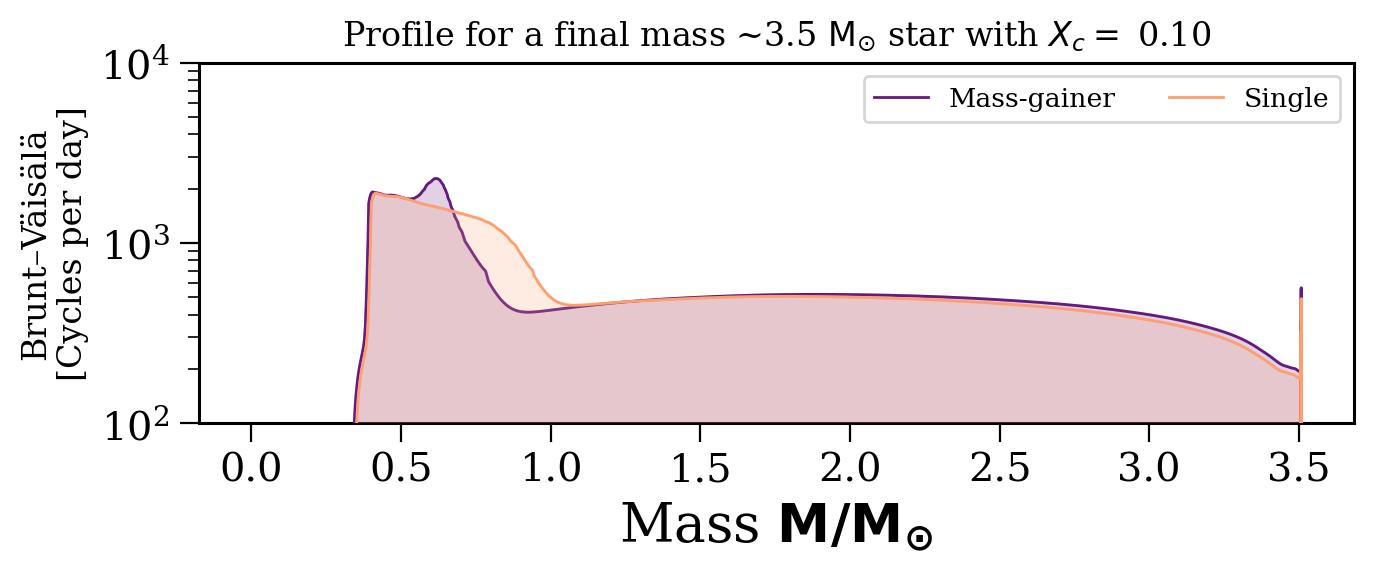

In [57]:
fig, ax = mesaplot.plot_BV_profile(X_c=0.1, tracks=D_mix_tracks, mt_index=0, ref_index=1, show=False)
ax.set_ylim(1e2, 1e4);

In [28]:
mt_brunt_r, mt_brunt_m = interpolate_brunt_N(D_mix_tracks[0], 238)
single_brunt_r, single_brunt_m = interpolate_brunt_N(D_mix_tracks[1], 141)

0.33903448842061296
0.058240390381147575
0.34679663399158867
0.055417635279060004


/tmp/ipykernel_8222/1180929855.py:11: RuntimeWarning: divide by zero encountered in divide
  dN_N = (mt_brunt_r(r_range) - single_brunt_r(r_range)) / single_brunt_r(r_range)
/tmp/ipykernel_8222/1180929855.py:11: RuntimeWarning: invalid value encountered in divide
  dN_N = (mt_brunt_r(r_range) - single_brunt_r(r_range)) / single_brunt_r(r_range)


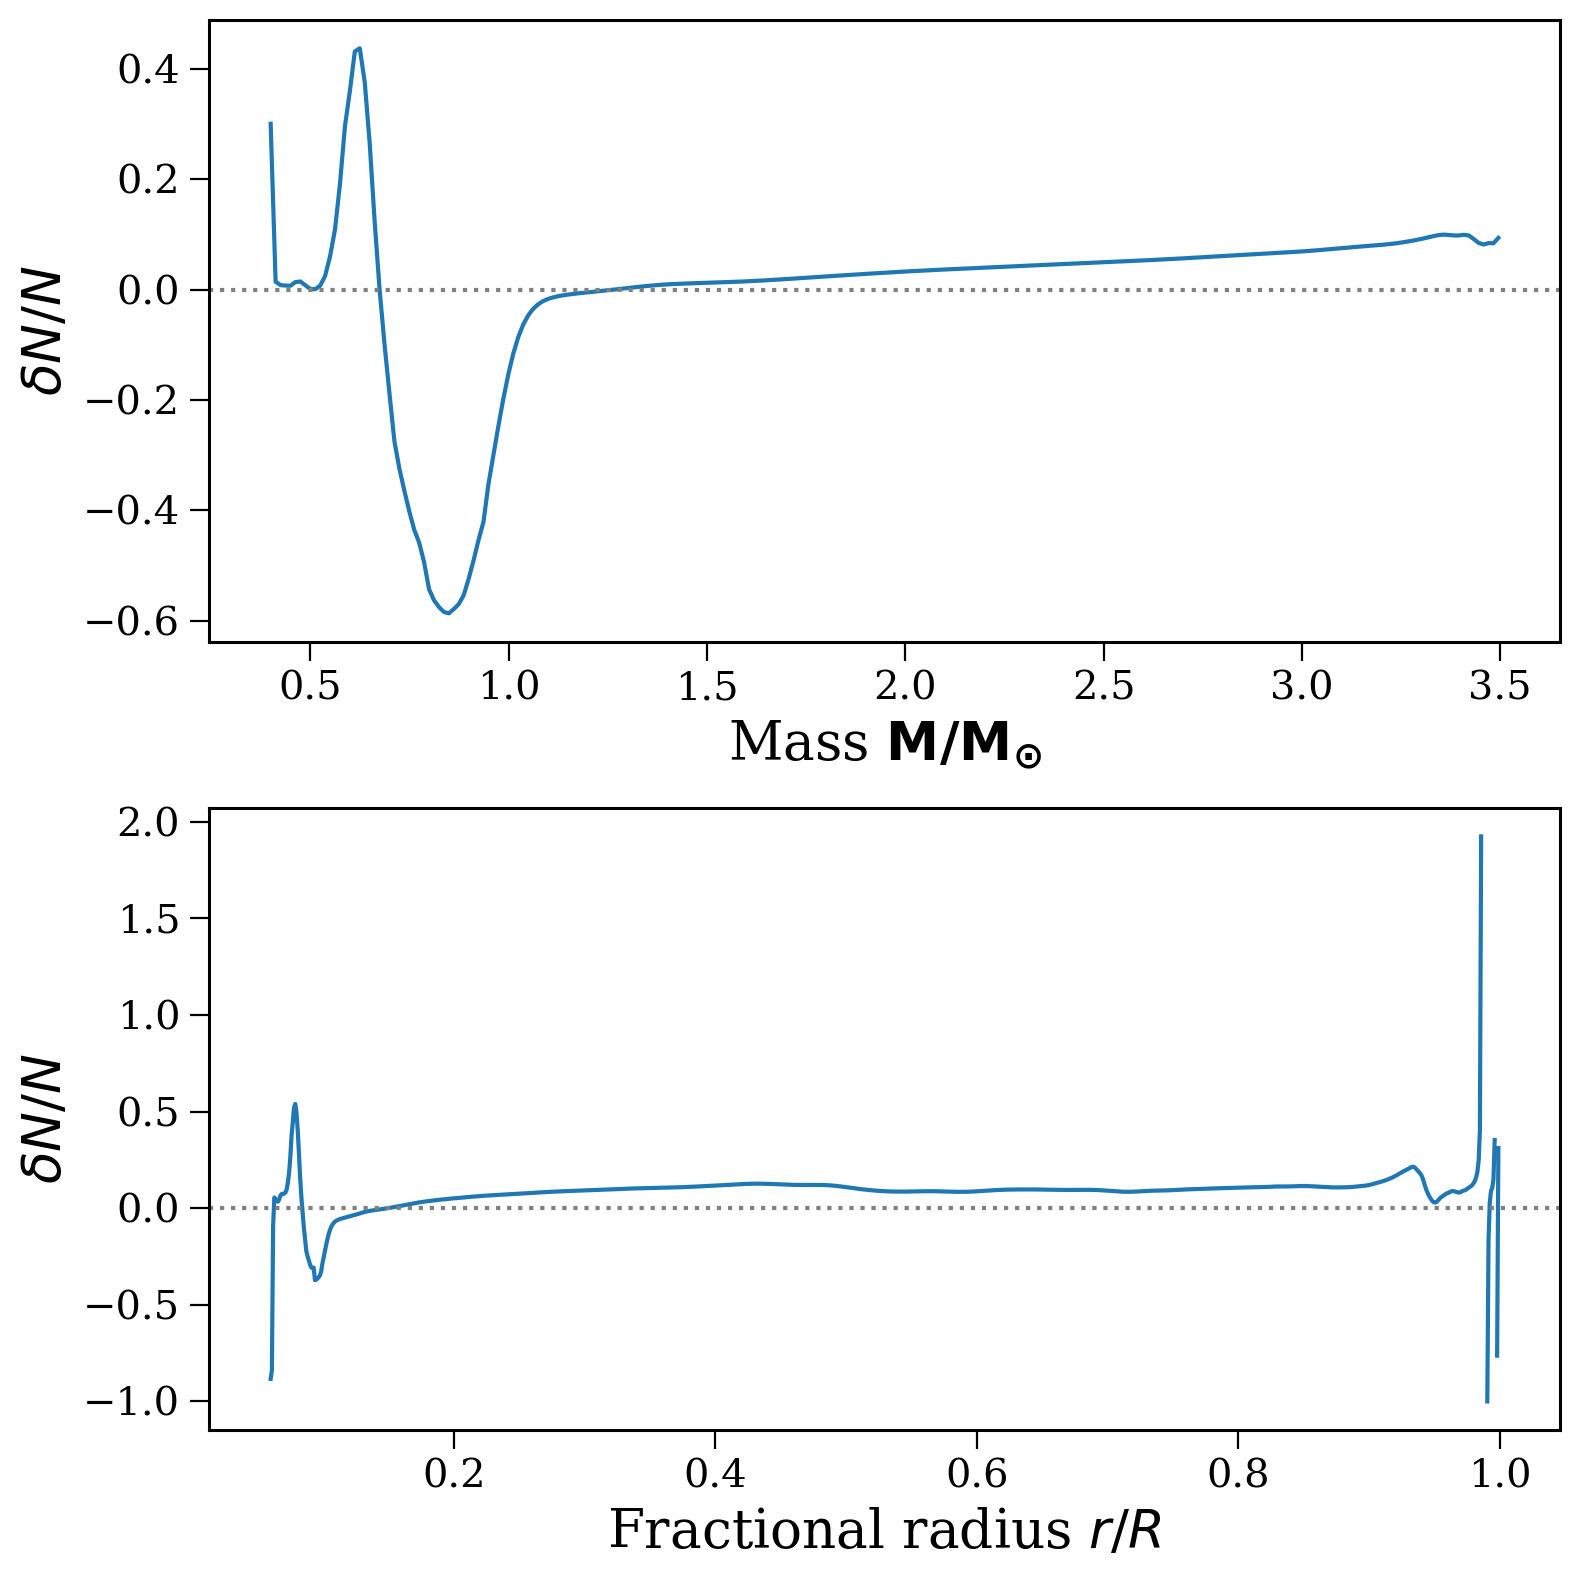

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

m_range = np.linspace(0.4, 3.508104, 250)
axes[0].plot(m_range, (mt_brunt_m(m_range) - single_brunt_m(m_range)) / single_brunt_m(m_range))
axes[0].set_xlabel(r"Mass $\mathbf{M/M_{\odot}}$")
axes[0].set_ylabel(r"$\delta N / N$")
axes[0].axhline(0, linestyle="dotted", color="grey")

r_range = np.linspace(0.06, 1, 1000)

dN_N = (mt_brunt_r(r_range) - single_brunt_r(r_range)) / single_brunt_r(r_range)
axes[1].plot(r_range, dN_N)
axes[1].set_xlabel(r"Fractional radius $r/R$")
axes[1].set_ylabel(r"$\delta N / N$")
axes[1].axhline(0, linestyle="dotted", color="grey")

plt.tight_layout()

plt.show()

In [44]:
r_lim = 0.98
np.trapz(y=np.nan_to_num(dN_N[r_range < r_lim]), x=r_range[r_range < r_lim])

0.07663338441419626

In [49]:
boundary_edge_range = np.linspace(core_boundary(D_mix_tracks[1], 141), r_lim, 1000)

In [50]:
pi0 = np.trapz(y=single_brunt_r(boundary_edge_range), x=boundary_edge_range)

In [53]:
pi0

0.0005448340638286466

In [242]:
from tomso import gyre

In [246]:
x = gyre.load_gyre("../output/mass_transfer_grid_with_D_mix/M_3-MT_0.4/LOGS/profile238.data.GYRE")

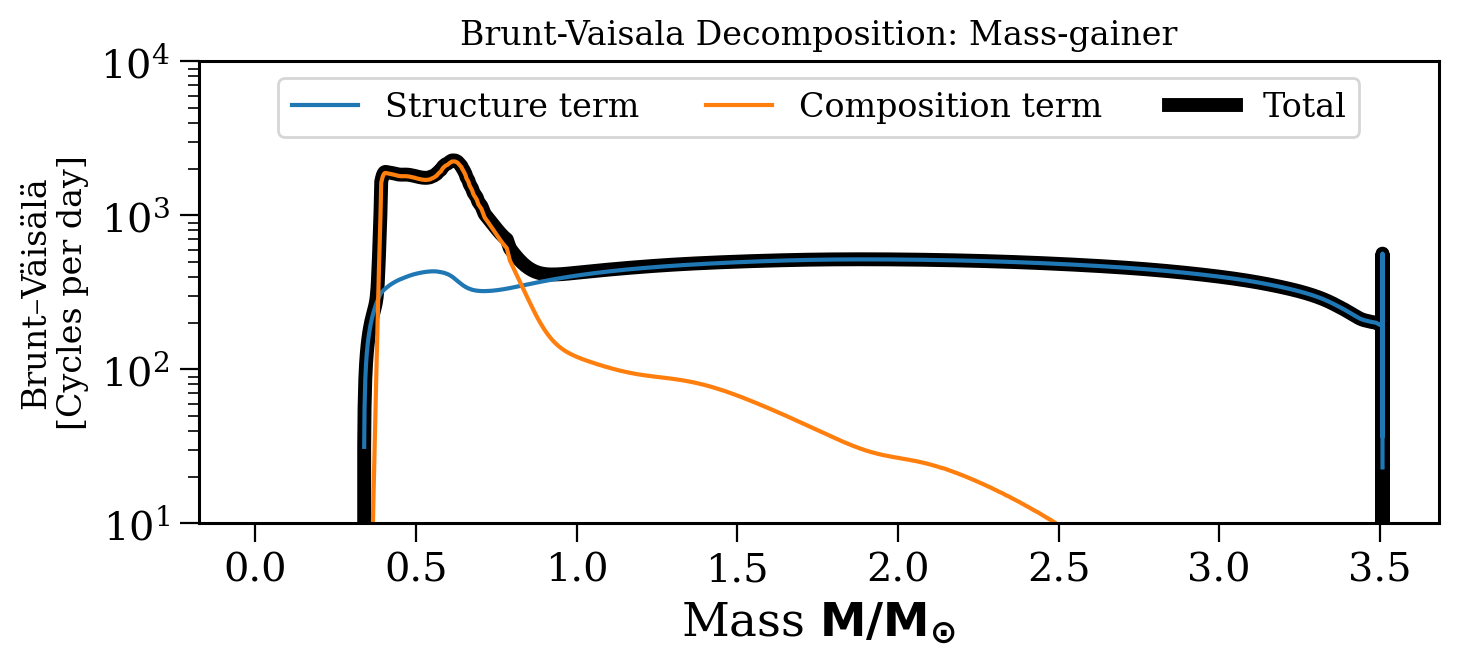

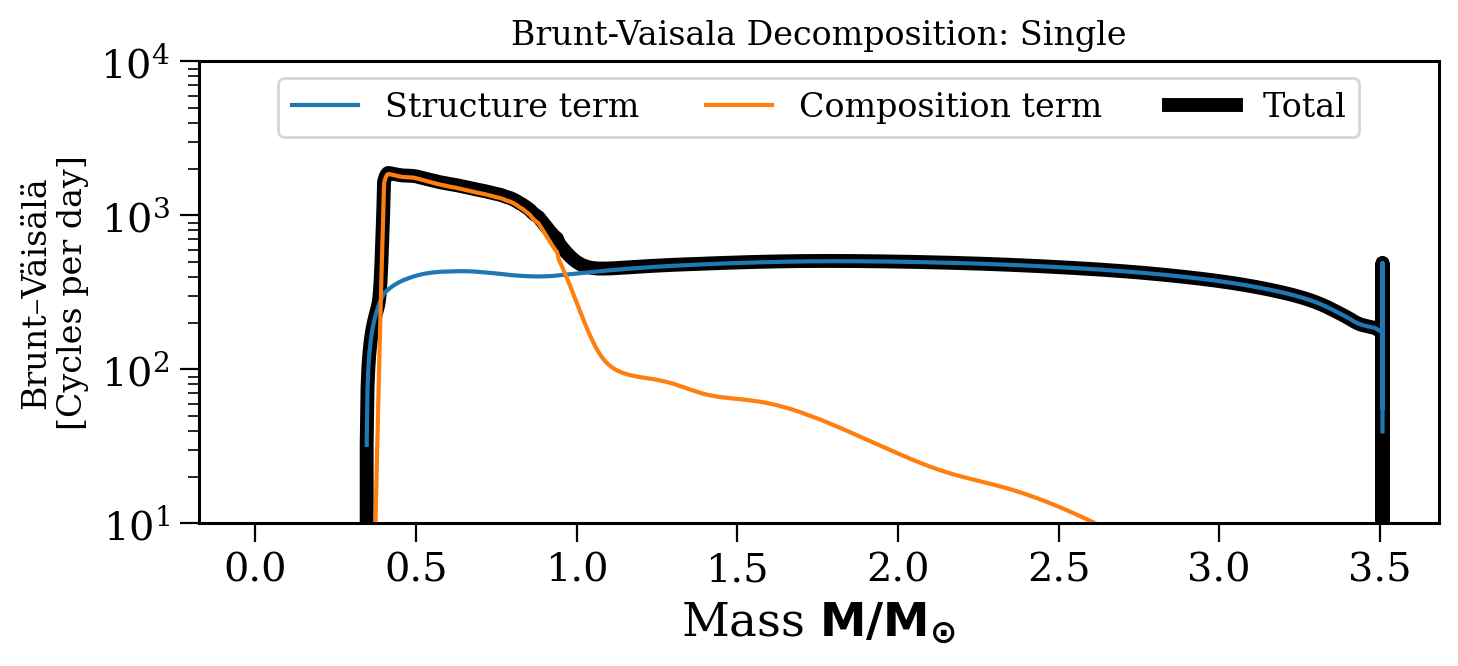

In [290]:
fac = ((2 * np.pi * u.Hz).to(u.day**(-1))).value


for p, label in zip([D_mix_tracks[0].profiles[238 - 1], D_mix_tracks[1].profiles[141 - 1]],
                    ["Mass-gainer", "Single"]):
    plt.figure(figsize=(8, 3))
    plt.plot(p["mass"], p["brunt_N2_structure_term"]**(0.5) * fac, label="Structure term")
    plt.plot(p["mass"], p["brunt_N2_composition_term"]**(0.5) * fac, label="Composition term")
    plt.plot(p["mass"], p["brunt_N"] * fac, color="black", lw=5, zorder=-1, label="Total")
    
    plt.yscale("log")
    plt.ylim(1e1, 1e4)
    
    plt.legend(ncols=3, fontsize=0.5*fs, loc="upper center")
    plt.title(f"Brunt-Vaisala Decomposition: {label}")
    
    plt.ylabel("Brunt–Väisälä\n[Cycles per day]", fontsize=0.5 * fs)
    plt.xlabel(r"Mass $\mathbf{M/M_{\odot}}$", fontsize=0.7 * fs)
    plt.show()